# Panel regression (NOT!)

An end to end tutorial on panel regression using wide format data.

## ENVIRONMENT

In [1]:
# import os

# For reproducibility
import random
random.seed(493)

# For manipulating dataframes
import pandas as pd
import numpy as np

# To print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv("../data/panel_data.csv")

# Preview the data
print(df.head())
print(df.dtypes)
print(df.isnull().sum())

   Client Name  Year  Billable_Hours        Gross
0  Tyler Group  2003          122958  14339272.16
1  Tyler Group  2007          138337  13433450.89
2  Tyler Group  2008          375871  32344489.21
3  Tyler Group  2009          322879  37484046.56
4  Tyler Group  2010          268455  32275246.70
Client Name        object
Year                int64
Billable_Hours      int64
Gross             float64
dtype: object
Client Name       0
Year              0
Billable_Hours    0
Gross             0
dtype: int64


In [3]:
# Simple column naming convention
df = df.rename(columns={
    "Client Name": "client",
    "Year": "year",
    "Billable_Hours": "hours",
    "Gross": "gross"
})

## EXPLORATORY DATA ANALYSIS

In [4]:
# Find total number of duplicate rows
df.duplicated().sum()
df.duplicated(subset=["client", "year"]).sum()


np.int64(0)

np.int64(0)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

def style_plot(ax=None):
    if ax is None:
        ax = plt.gca()

    # Set figure size
    fig = ax.get_figure()
    fig.set_size_inches(12, 8)

    # Custom formatter for large y-axis values
    def human_format(x, pos):
        abs_x = abs(x)
        if abs_x >= 1_000_000_000:
            val = x / 1_000_000_000
            suffix = 'B'
        elif abs_x >= 1_000_000:
            val = x / 1_000_000
            suffix = 'M'
        elif abs_x >= 1_000:
            val = x / 1_000
            suffix = 'K'
        else:
            val = x
            suffix = ''
        
        if val.is_integer():
            return f"{val:,.0f}{suffix}"
        else:
            return f"{val:,.1f}{suffix}"

    # Detect if x-axis is a "year"
    x_ticks = np.array(ax.get_xticks())  # ✅ Convert list to array
    is_year_axis = np.all((x_ticks >= 1900) & (x_ticks <= 2100)) and np.all(x_ticks.astype(int) == x_ticks)


    # Format x-axis accordingly
    if is_year_axis:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x)}"))
    else:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))

    # Apply y-axis formatter
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(human_format))

    # Layout and style
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')
    fig.tight_layout()

    return ax

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Distribution of Hours')

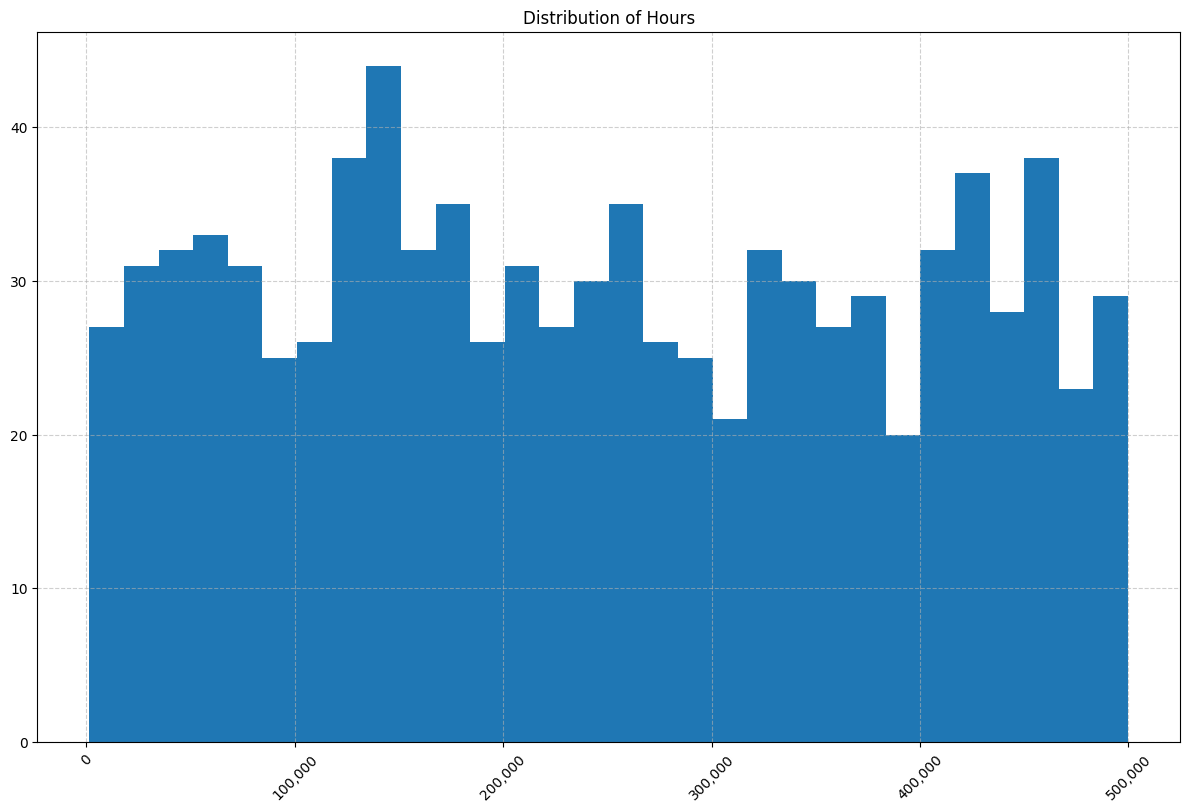

In [6]:
# Distribution of key variables

df["hours"].hist(bins=30)
style_plot()
plt.title("Distribution of Hours")
plt.show()

Distribution of Hours:
- Fairly uniform
- No obvious skew or outliers
- The shape is good for regression - means there's a wide spread of values and relatively even coverage

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Distribution of Gross')

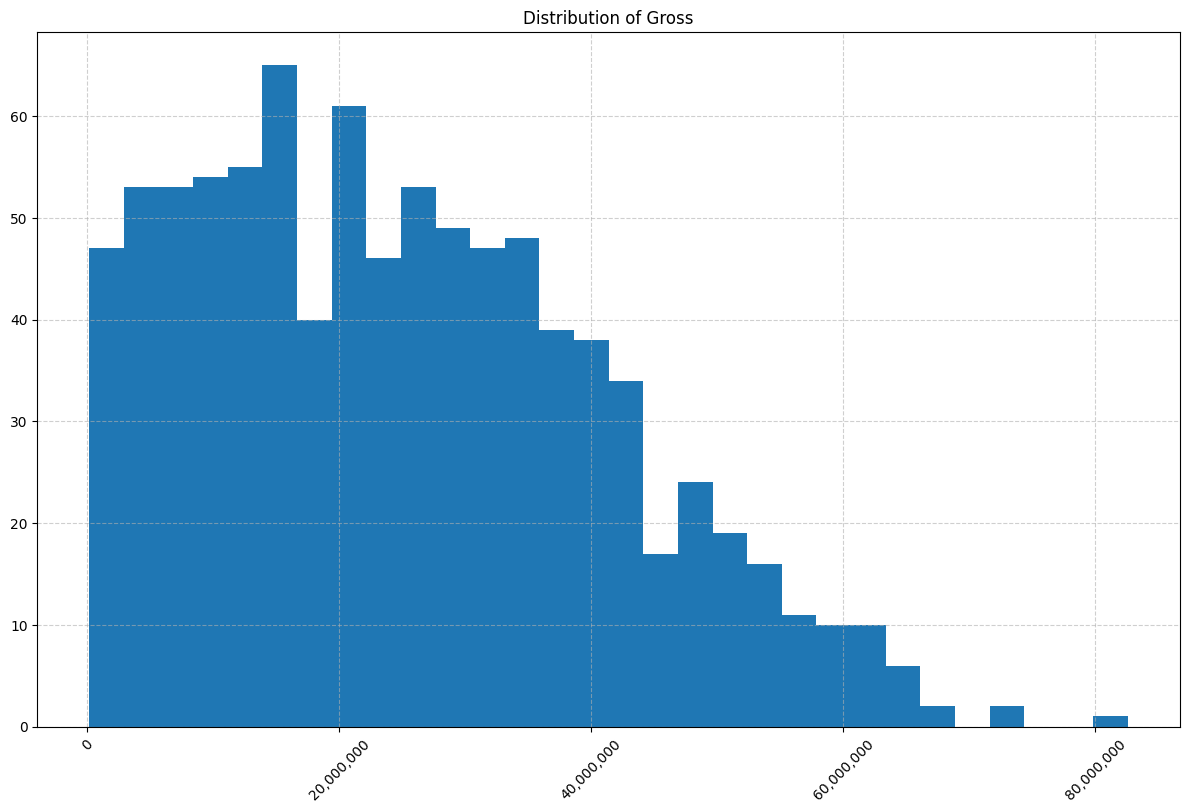

In [7]:
df["gross"].hist(bins=30)
style_plot()
plt.title("Distribution of Gross")
plt.show()

Distribution of Gross:
- Right skewed - heavily concentrated on the left side (lower gross) with long tail to the right
- Lots of observations arounf 10M - 30M but some go above 60M - 80M
- Indicates a few clients or years are bringing much higher gross revenue, which could:
        - Create heteroskedasticity
        - Influence regression results
        - Suggest outliers worth flagging    

Why we might to log-transform gross: If the target variable is heavily right-skewed like this one, it may do the following:
- Violate linear regression assumptions of normal residuals and homoscedasticity
- Lead to a model that’s overly influenced by high-value outliers

TODO: Let's log-transform gross later and compare models to see if it affects the results.

<Axes: xlabel='hours', ylabel='gross'>

<Axes: xlabel='hours', ylabel='gross'>

Text(0.5, 1.0, 'Gross vs Hours')

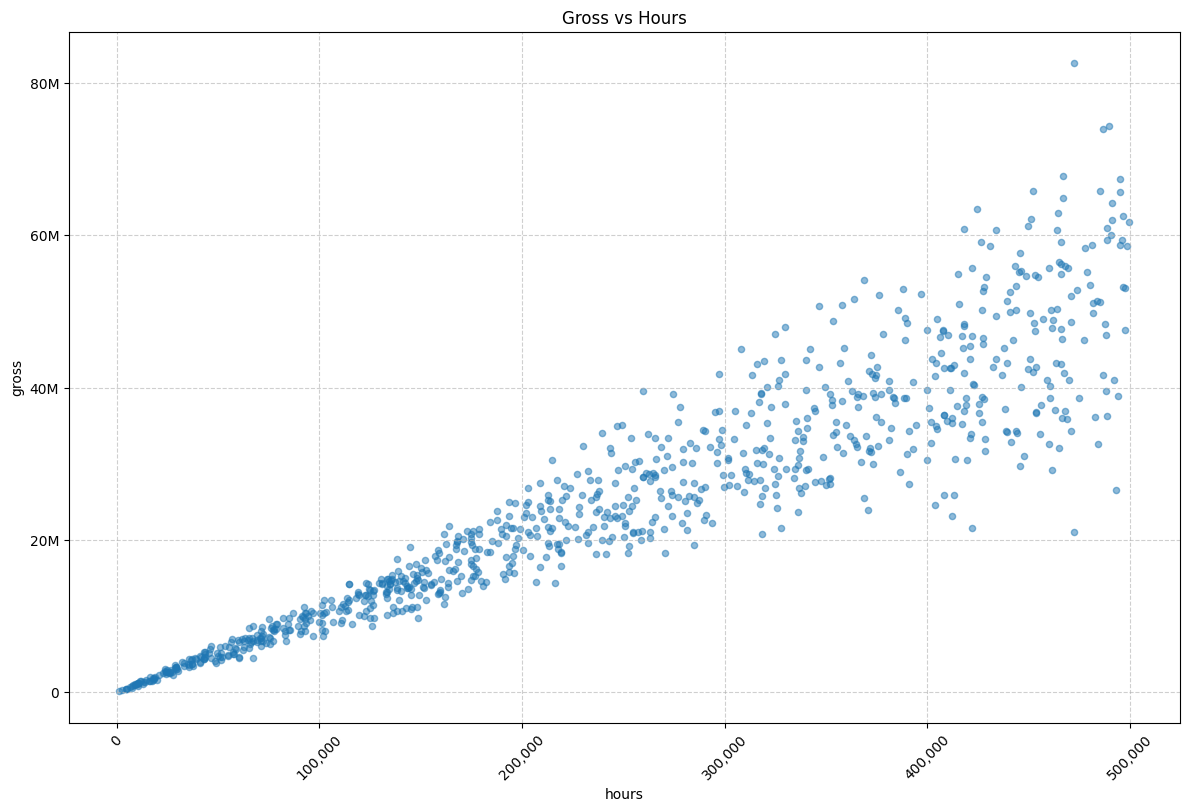

In [8]:
# Relation between Hours and Gross
df.reset_index().plot.scatter(x="hours", y="gross", alpha=0.5)
style_plot()
plt.title("Gross vs Hours")
plt.show()

Interpretation: Gross vs Hours

| **Observation**                    | **Insight**                                                                 |
|-----------------------------------|-----------------------------------------------------------------------------|
| Strong upward trend               | As expected: more hours → more gross. The relationship is clearly positive. |
| Curve-like pattern (non-linear)   | Suggests some non-linearity or increasing variance at higher `hours` — likely from noise scaling with hours. |
| Wider spread at high `hours`      | Indicates heteroskedasticity — variance in `gross` increases with `hours`. |
| No major outliers off-pattern     | Most data follows a logical trend — no significant anomalies.               |

What this tells us:
- Your simulated data captures a realistic billing scenario: more work = more money, but with varying margins.
- This would support:
        - A log-log transformation for linear modeling
        - Checking for heteroskedasticity in your regression residuals
- A simple linear model may underestimate uncertainty at high hours.

TODO: Let's log-log transform gross later and compare models to see if it affects the results.

<Axes: xlabel='year'>

<Axes: xlabel='year'>

Text(0.5, 1.0, 'Yearly Average Gross and Hours')

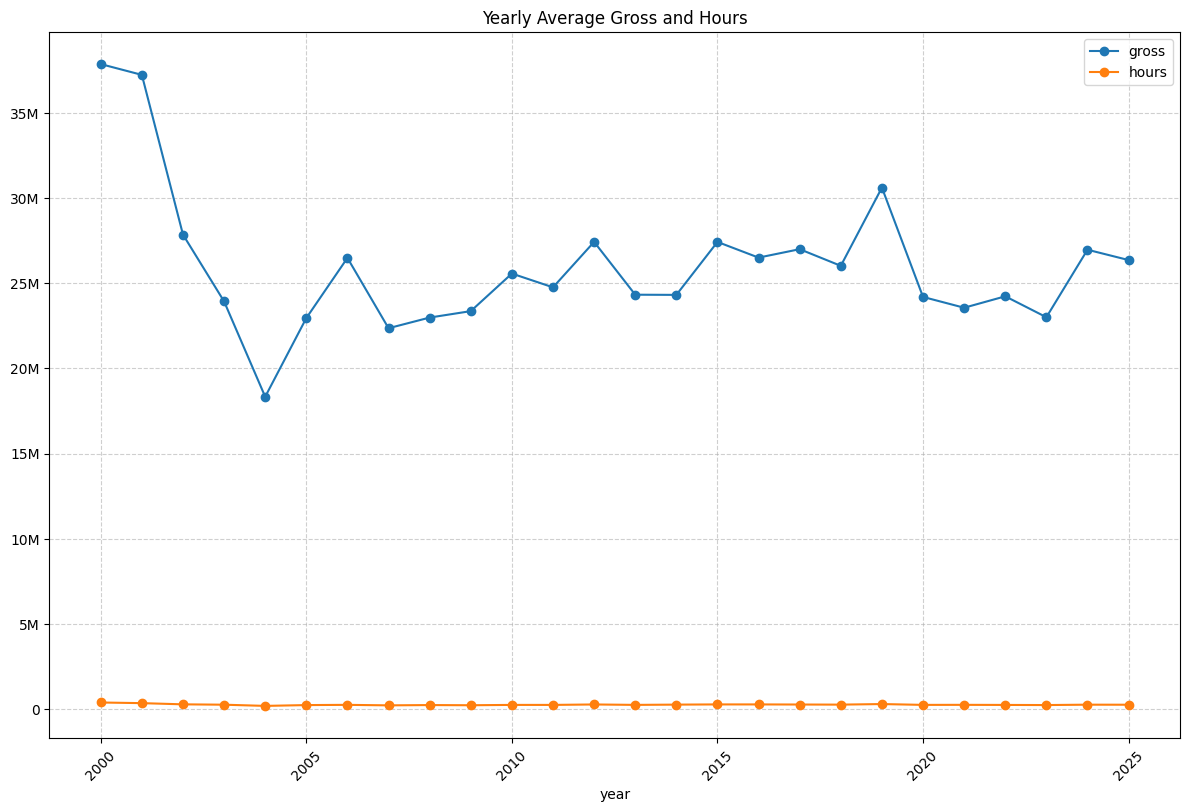

In [9]:
# Trend over time
df.reset_index().groupby("year")[["gross", "hours"]].mean().plot(marker="o")
style_plot()
plt.title("Yearly Average Gross and Hours")
plt.show()

Interpretation: Yearly Trends

| **Observation**                       | **Insight**                                                                 |
|--------------------------------------|------------------------------------------------------------------------------|
| 📉 Sharp drop in gross after 2000–2001 | Early years may reflect small sample bias or a few high-revenue clients     |
| 📈 Stabilization from ~2005 onward    | Gross levels out around $25M–$27M — relatively steady trend                 |
| 🔸 Hours stay flat                    | Suggests operational effort is stable over time                             |
| 🔍 Gross varies independently         | Revenue likely influenced by billing rates, client mix, or contract type    |

What This Tells Us
- There's weak alignment between hours and gross on a year-over-year basis — volume of work is stable, but revenue fluctuates.
- Reinforces that we should explore gross per hour, pricing strategies, or client types to explain variation.
- May also be worth inspecting those 2000–2002 years — possibly outliers or sparsely sampled.

Let's plot on dual y-axes for better visibility. 

Text(0, 0.5, 'Gross')

Text(0, 0.5, 'Hours')

<Axes: ylabel='Hours'>

Text(0.5, 1.0, 'Yearly Average Gross and Hours (Dual Axis)')

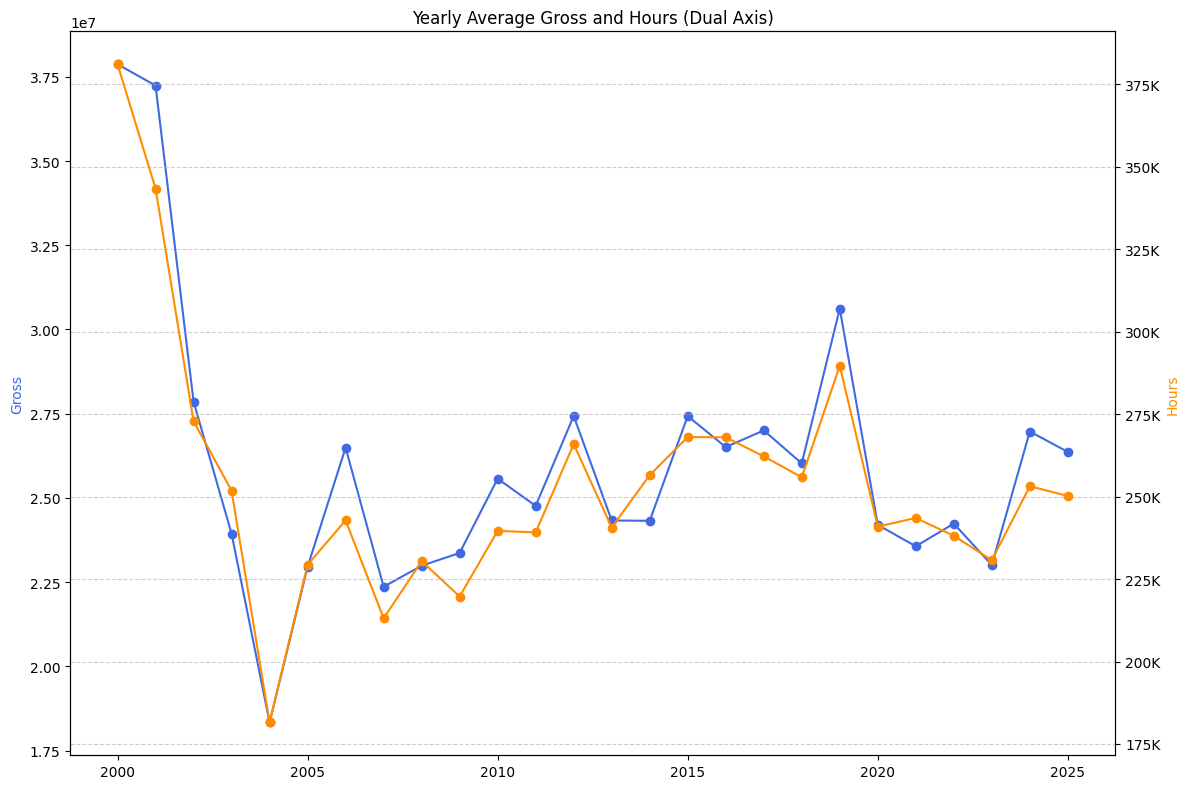

In [10]:
yearly = df.reset_index().groupby("year")[["gross", "hours"]].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(12, 8))

ax2 = ax1.twinx()
ax1.plot(yearly["year"], yearly["gross"], color="royalblue", marker="o", label="Gross")
ax2.plot(yearly["year"], yearly["hours"], color="darkorange", marker="o", label="Hours")

ax1.set_ylabel("Gross", color="royalblue")
ax2.set_ylabel("Hours", color="darkorange")
style_plot()
ax1.set_title("Yearly Average Gross and Hours (Dual Axis)")
fig.tight_layout()
plt.show()


Yearly Average Gross and Hours (Dual Axis)

| **Observation**                                | **Insight**                                                                 |
|------------------------------------------------|------------------------------------------------------------------------------|
| 📉 Early-year dip (2000–2004)                  | Sparse client-year entries lead to inflated or unstable averages            |
| 📈 Strong alignment post-2005                  | Hours and gross rise and fall together, showing a labor-driven revenue model |
| 🔄 Parallel movement year-to-year              | Suggests billing consistency — per-hour rates are relatively stable          |
| 🎯 Gross tracks hours reliably                 | Hours is a good predictor of gross in later years                           |
| 🧯 Slight divergence around 2020               | Possibly due to event shock or contract changes affecting revenue more than labor, like the pandemic! |

What This Tells Us
- Post-2005, your simulation reflects a strong operational relationship between work done and revenue.
- There's no big structural break — good sign for using panel regression on this period.
- Any divergence (e.g. 2020 dip in gross) could be a natural place to introduce events, shocks, or rate changes in a future model.

<Axes: xlabel='client'>

Text(0.5, 1.0, 'Average Gross and Hours by Client')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),
 [Text(0, 0, 'Adams Group'),
  Text(1, 0, 'Anderson, Fernandez and Rodriguez'),
  Text(2, 0, 'Baker Ltd'),
  Text(3, 0, 'Benson and Sons'),
  Text(4, 0, 'Brown Ltd'),
  Text(5, 0, 'Brown-Benson'),
  Text(6, 0, 'Camacho, Morris and Rios'),
  Text(7, 0, 'Carr-Ray'),
  Text(8, 0, 'Carter Ltd'),
  Text(9, 0, 'Carter, Olson and Butler'),
  Text(10, 0, 'Chandler, Brown and Robinson'),
  Text(11, 0, 'Collins Group'),
  Text(12, 0, 'Curtis-Carroll'),
  Text(13, 0, 'Davis-Allen'),
  Text(14, 0, 'Diaz Ltd'),
  Text(15, 0, 'Dodson, Gray and Vargas'),
  Text(1

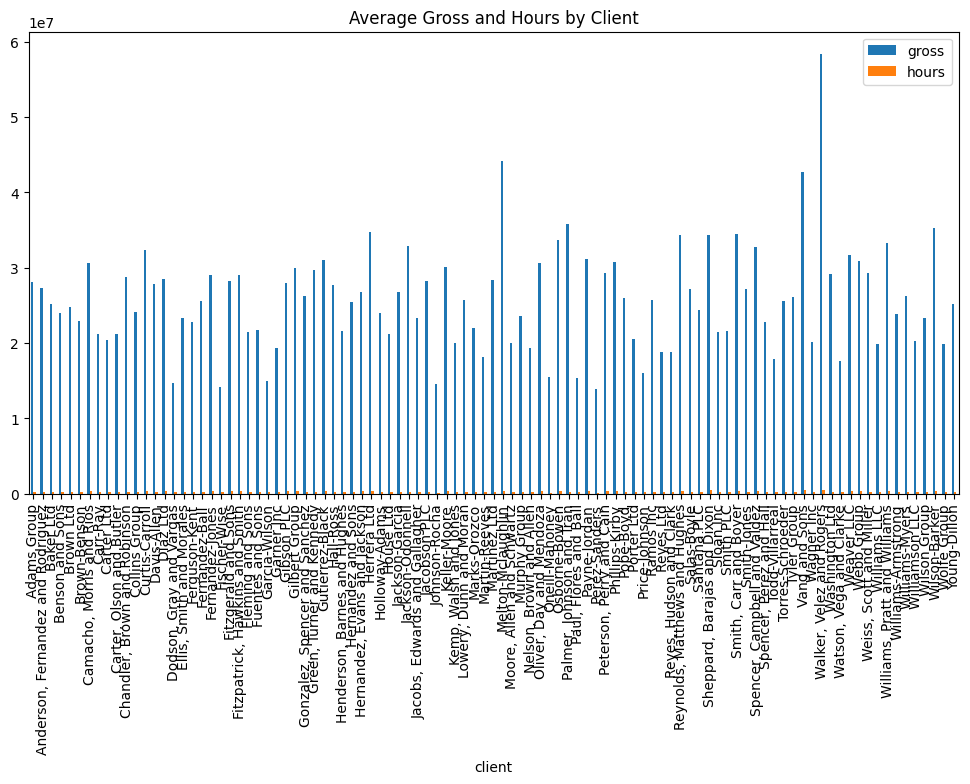

In [11]:
# Client-level variation
df.reset_index().groupby("client")[["gross", "hours"]].mean().plot(kind="bar", figsize=(12, 6))
plt.title("Average Gross and Hours by Client")
plt.xticks(rotation=90)
plt.show()

What This Tells Us
- Gross and hours don’t move together here — some clients get much higher revenue per hour.
- Supports the idea of analyzing efficiency via Gross per Hour by client.
- These client-level differences may reflect segment-level differences or billing strategies — worth exploring further.

<Axes: title={'center': 'Average Gross by Client'}, xlabel='client'>

<Axes: title={'center': 'Average Gross by Client'}, xlabel='client'>

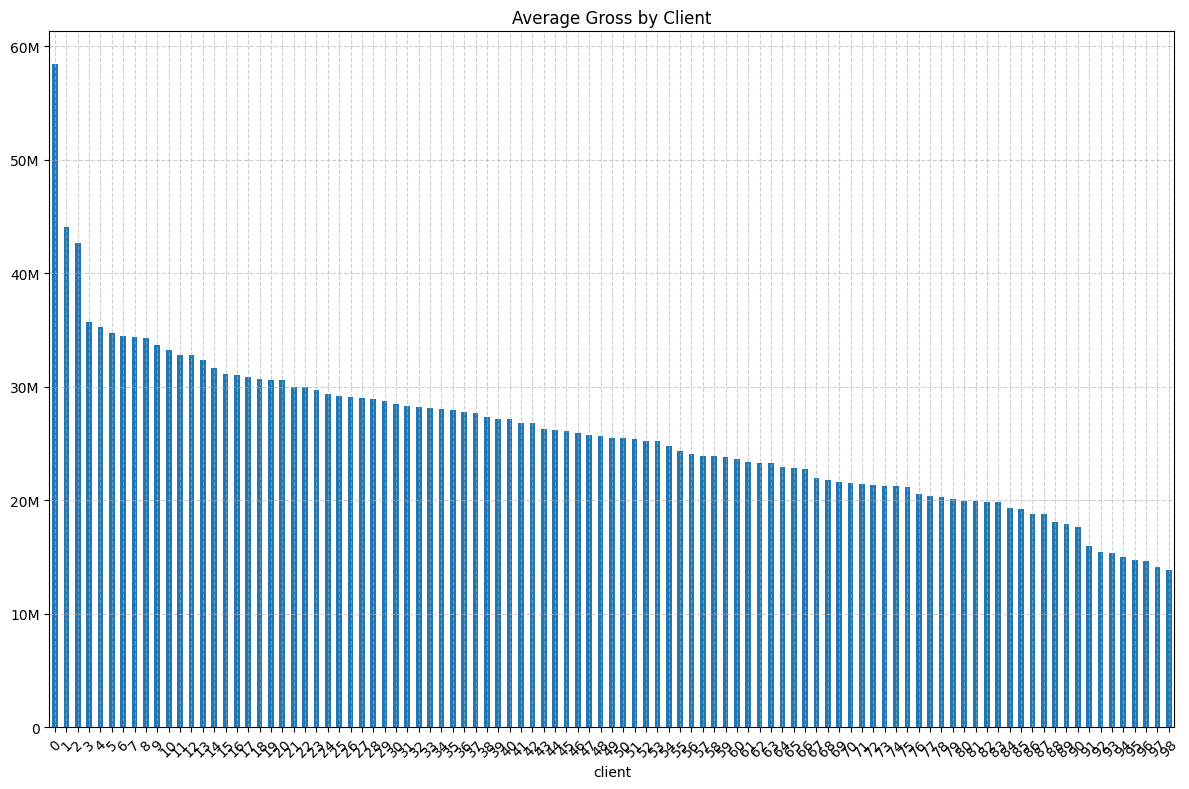

<Axes: title={'center': 'Average Hours by Client'}, xlabel='client'>

<Axes: title={'center': 'Average Hours by Client'}, xlabel='client'>

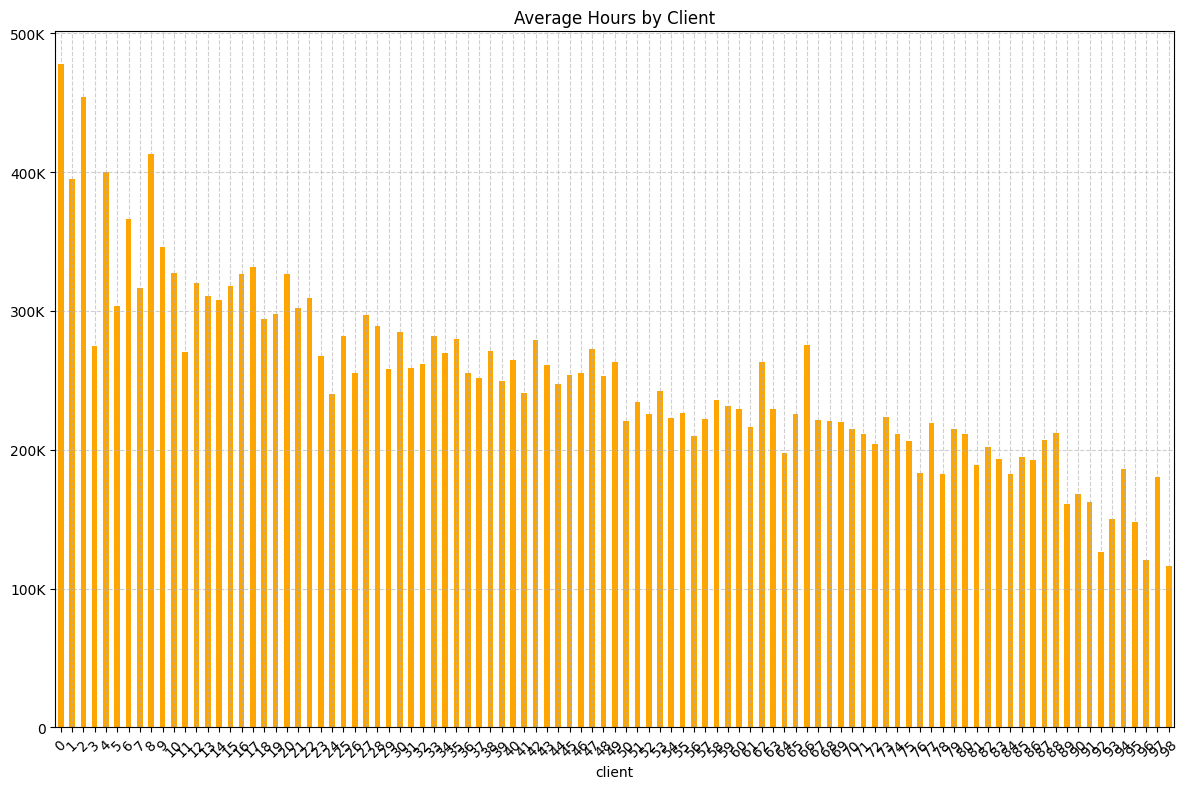

In [12]:
# Separate bar plots
avg_by_client = df.groupby("client")[["gross", "hours"]].mean().sort_values("gross", ascending=False)

avg_by_client["gross"].plot(kind="bar", figsize=(12, 6), title="Average Gross by Client")
style_plot()
plt.tight_layout()
plt.show()

avg_by_client["hours"].plot(kind="bar", figsize=(12, 6), color="orange", title="Average Hours by Client")
style_plot()
plt.tight_layout()
plt.show()

Average Gross vs Hours by Client

| **Observation**                              | **Insight**                                                                 |
|----------------------------------------------|------------------------------------------------------------------------------|
| Top gross clients not always top hours     | Some high-grossing clients don’t require as many hours — these are likely high-efficiency, high-rate clients |
| Ranking differences                        | Gross and hours aren’t perfectly aligned — this confirms variation in rates or contract structures |
| Long tail                                  | Both metrics show a steep drop-off — a few key clients drive most revenue and effort, while many contribute modestly |
| Efficiency varies                          | Some clients deliver more revenue per hour than others — a strong case for analyzing gross per hour (GPH) |
| Strategic segmentation                     | This view supports client tiering — e.g., high gross + low hours = ideal clients |

What This Tells Us
- You’ve got diverse client types: some pay more per hour, others generate volume.
- There’s strong justification for calculating and visualizing Gross per Hour to flag:
    - Top performers
    - Cost centers
- Helpful for targeting, pricing strategy, or contract reviews

Let's flag the top and bottom clients based on their average gross by hour.

In [13]:
avg_by_client = df.groupby("client")[["gross", "hours"]].mean()
avg_by_client["gross_per_hour"] = avg_by_client["gross"] / avg_by_client["hours"]

# Top 5 clients (star performers)
top_clients = avg_by_client.sort_values("gross_per_hour", ascending=False).head(5)

# Bottom 5 clients (cost centers)
bottom_clients = avg_by_client.sort_values("gross_per_hour", ascending=True).head(5)

# Format each column individually using .map
formatted_top = top_clients.round(0).copy()
formatted_top["gross"] = formatted_top["gross"].map(lambda x: f"${x:,.0f}")
formatted_top["hours"] = formatted_top["hours"].map(lambda x: f"{x:,.0f}")
formatted_top["gross_per_hour"] = formatted_top["gross_per_hour"].map(lambda x: f"${x:,.0f}")

formatted_bottom = bottom_clients.round(0).copy()
formatted_bottom["gross"] = formatted_bottom["gross"].map(lambda x: f"${x:,.0f}")
formatted_bottom["hours"] = formatted_bottom["hours"].map(lambda x: f"{x:,.0f}")
formatted_bottom["gross_per_hour"] = formatted_bottom["gross_per_hour"].map(lambda x: f"${x:,.0f}")

print("🔝 Top 5 Clients by Gross per Hour:\n")
print(formatted_top)

print("\n🔻 Bottom 5 Clients by Gross per Hour:\n")
print(formatted_bottom)




🔝 Top 5 Clients by Gross per Hour:

                                gross    hours gross_per_hour
client                                                       
Palmer, Johnson and Tran  $35,738,847  274,743           $130
Oneill-Mahoney            $15,469,955  126,425           $122
Walker, Velez and Rogers  $58,414,808  477,657           $122
Weiss, Scott and Miller   $29,333,584  240,429           $122
Jackson-Odonnell          $32,814,079  270,542           $121

🔻 Bottom 5 Clients by Gross per Hour:

                                   gross    hours gross_per_hour
client                                                          
Fischer-Wise                 $14,091,332  180,216            $78
Garcia-Wilson                $14,964,408  186,219            $80
Spencer, Perez and Hall      $22,800,713  275,280            $83
Sheppard, Barajas and Dixon  $34,292,137  413,022            $83
Martin-Reeves                $18,104,383  211,837            $85


In [14]:
print(df[["hours", "gross"]].corr())

          hours     gross
hours  1.000000  0.929839
gross  0.929839  1.000000


<Figure size 600x500 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Correlation Between Hours and Gross')

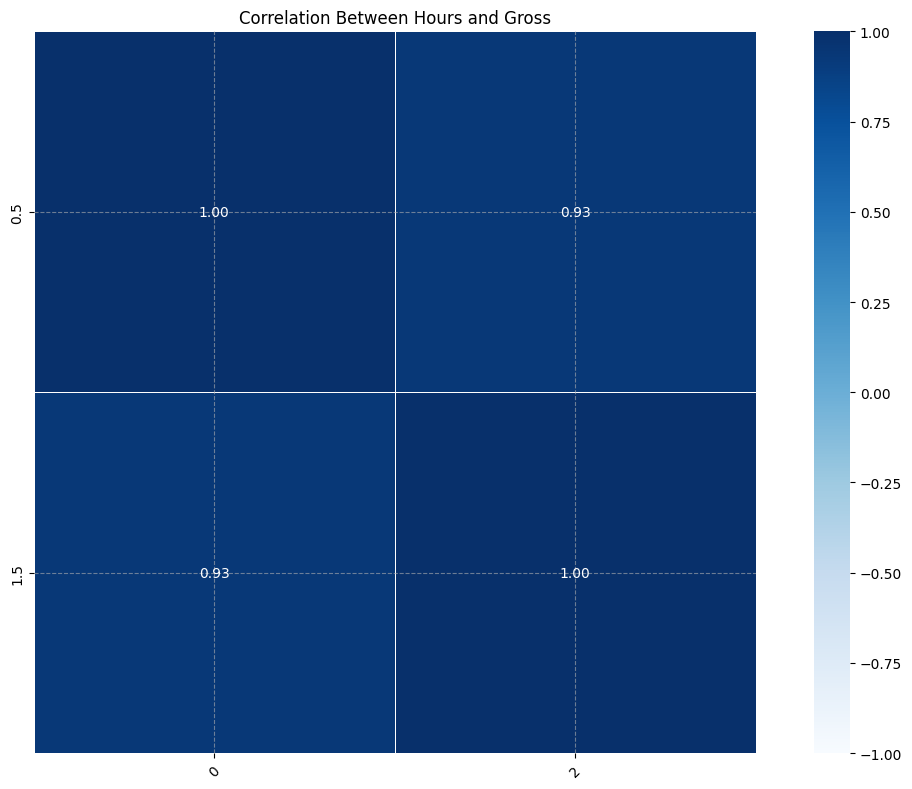

In [15]:
import seaborn as sns

# Calculate correlation matrix
corr = df[["hours", "gross"]].corr()

# Plot as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", vmin=-1, vmax=1, square=True, linewidths=0.5)
style_plot()
plt.title("Correlation Between Hours and Gross")
plt.tight_layout()
plt.show()

| **Observation**                  | **Insight**                                                                 |
|----------------------------------|------------------------------------------------------------------------------|
| ✅ High correlation (0.93)        | Strong linear relationship — as `Hours` rise, `Gross` follows proportionally |
| 🔁 Symmetric relationship         | Confirms that both variables consistently co-vary                             |
| 📈 Ideal for modeling             | `Hours` is a strong predictor for `Gross` in regression models               |
| ⚠️ Watch for multicollinearity   | Be cautious when adding more predictors that could overlap with `Hours`     |

What This Tells Us
- Hours is a solid standalone predictor of Gross.
- You could confidently start modeling using Hours as your main feature.
- If you log-transform Gross, it could help address heteroskedasticity without harming the predictive power of Hours.

TODO: Let's log-transform gross later and compare models to see if it affects the results.

<Figure size 1200x500 with 0 Axes>

<Axes: >

<Axes: ylabel='hours'>

Text(0.5, 1.0, 'Boxplot of Hours')

<Axes: >

<Axes: ylabel='gross'>

Text(0.5, 1.0, 'Boxplot of Gross')

<Axes: title={'center': 'Boxplot of Gross'}, ylabel='gross'>

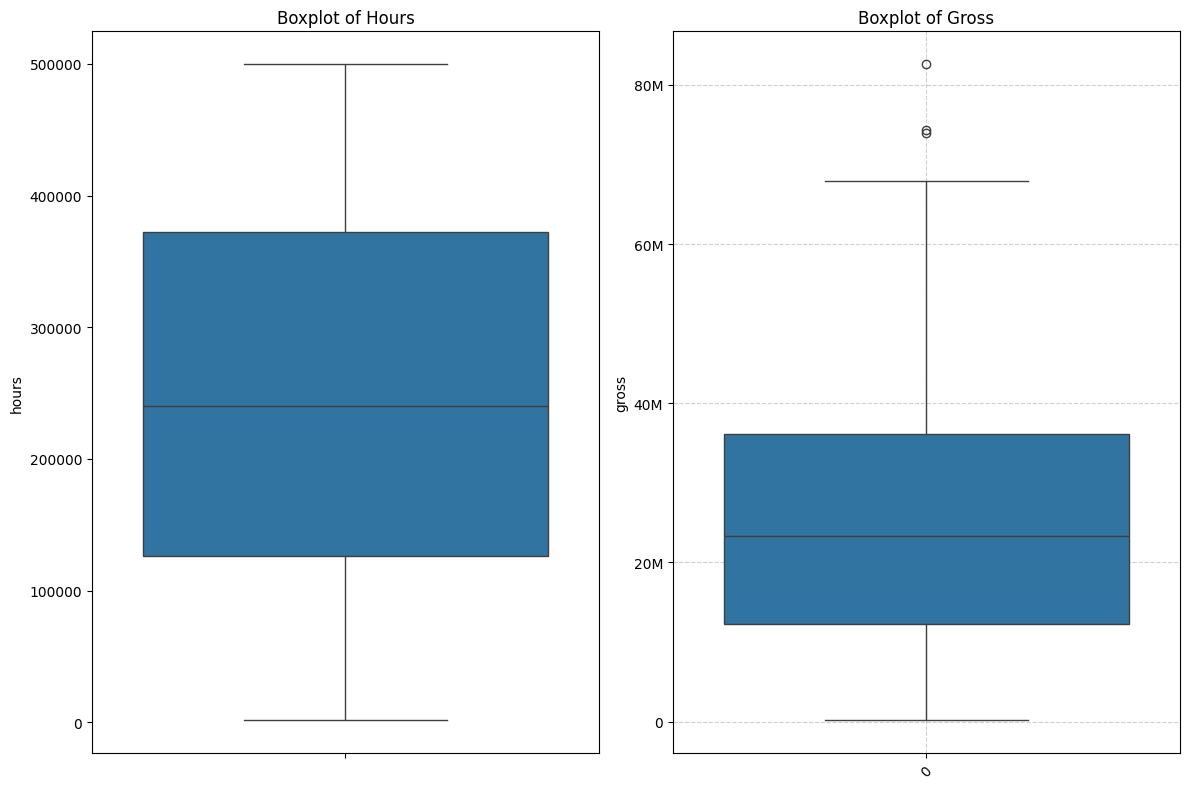

In [16]:
# Detect outliers (Visual and Statistical)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df["hours"])
plt.title("Boxplot of Hours")

plt.subplot(1, 2, 2)
sns.boxplot(y=df["gross"])
plt.title("Boxplot of Gross")

style_plot()
plt.tight_layout()
plt.show()


| **Feature** | **Observation**                            | **Insight**                                                                 |
|-------------|---------------------------------------------|------------------------------------------------------------------------------|
| `Hours`     | ✅ Symmetrical with no extreme outliers     | Balanced distribution — no transformation needed                            |
|             | 📊 Moderate IQR spread                      | Some variability between clients/years                                       |
| `Gross`     | ⚠️ Right-skewed with visible outliers       | A few clients generate far more revenue — likely high-value contracts       |
|             | 🧯 Points above whisker                     | Suggest strong tail — transformation may improve model fit and stability    |
|             | 🔍 Median < Q3                              | Skew supports log transformation for regression                             |

What This Tells Us
- Hours is well-behaved and ready for use in regression models.
- Gross contains extreme values that could:
    - Skew model coefficients
    - Inflate error metrics
- Applying a log transformation to Gross is a reasonable next step.

TODO: Let's log-transform gross later and compare models to see if it affects the results.

In [17]:
# Statistical
 
from scipy.stats import zscore

z_scores = df[["hours", "gross"]].apply(zscore)
outliers = df[(abs(z_scores["gross"]) > 3) | (abs(z_scores["hours"]) > 3)]

print(f"Outlier count: {len(outliers)}")
display(outliers)

Outlier count: 3


,client,year,hours,gross
356,"Weiss, Scott and Miller",2022,472555,82601179.36
457,Phillips-Kirby,2024,489910,74325313.42
746,"Fitzpatrick, Hawkins and Smith",2013,486988,73919563.27


## PREP THE DATA

In [18]:
# Sort and set multi-index for panel structure
df = df.sort_values(by=["client", "year"])
df = df.set_index(["client", "year"])

In [19]:
df.head()

hours        gross
client      year                     
Adams Group 2006  106983   9277640.96
            2007  439452  51369755.24
            2008  125019  11049645.34
            2009  255079  26860313.48
            2010  417309  46860918.25

## MODELING

### Base Model

In [20]:
from linearmodels.panel import PanelOLS
import pandas as pd

# Define model
model = PanelOLS(df["gross"], df[["hours"]], entity_effects=True)

# Fit
results = model.fit()

# Summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  gross   R-squared:                        0.8653
Estimator:                   PanelOLS   R-squared (Between):              0.9905
No. Observations:                 900   R-squared (Within):               0.8653
Date:                Sun, Apr 06 2025   R-squared (Overall):              0.9603
Time:                        04:04:24   Log-likelihood                -1.526e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5139.0
Entities:                          99   P-value                           0.0000
Avg Obs:                       9.0909   Distribution:                   F(1,800)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             5139.0
                            

| **Metric**                   | **Value**         | **Interpretation**                                                                 |
|-----------------------------|-------------------|-------------------------------------------------------------------------------------|
| `R-squared (within)`        | **0.8653**         | Model explains ~86.5% of the within-client variation in `gross` using `hours`. Very strong fit. |
| `hours` coefficient          | **105.31**         | Each additional billable hour increases `gross` by ~$105, controlling for client effects. |
| `T-stat` for `hours`         | **71.69**          | Extremely significant. Effect is statistically very strong (`p < 0.0001`).         |
| `F-test for Poolability`     | **p = 0.5184**     | No strong evidence against pooling — fixed effects model remains appropriate.      |
| `R-squared (between)`        | **0.9905**         | Between-client variation in `gross` is almost fully explained by `hours`.          |
| `Entities / Observations`    | **99 clients / 900 obs** | Clean panel dataset, strong structure for reliable modeling.               |

Key Takeaways:
- Hours is a powerful predictor of Gross — both across and within clients.
- The relationship is stable, linear, and fits extremely well.
- There’s still client-specific variation handled by the fixed effects.
- The coefficient ~$105/hour seems realistic and interpretable.

### Log Transform

In [21]:
df["log_gross"] = np.log(df["gross"])
model_log = PanelOLS(df["log_gross"], df[["hours"]], entity_effects=True)
results_log = model_log.fit()
print(results_log.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_gross   R-squared:                        0.7745
Estimator:                   PanelOLS   R-squared (Between):              0.1663
No. Observations:                 900   R-squared (Within):               0.7745
Date:                Sun, Apr 06 2025   R-squared (Overall):              0.1649
Time:                        04:04:24   Log-likelihood                   -493.03
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2748.3
Entities:                          99   P-value                           0.0000
Avg Obs:                       9.0909   Distribution:                   F(1,800)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             2748.3
                            

| **Metric**              | **Value**    | **Interpretation**                                                                 |
|-------------------------|--------------|-------------------------------------------------------------------------------------|
| `R-squared (within)`    | **0.7745**   | ~77.5% of within-client variation in `log(gross)` is explained by `hours` — still strong |
| `hours` coefficient     | **5.78e-06** | Each additional hour increases `log(gross)` slightly → interpretable as ~0.000578% increase in `gross` per hour |
| `T-stat for hours`      | **52.43**    | Very strong statistical significance (`p < 0.0001`)                                 |
| `R-squared (between)`   | **0.1663**   | Lower between-client fit — expected in log models, especially with fixed effects    |
| `F-test for Poolability`| **p = 0.3141** | No strong reason to reject poolability — fixed effects still appropriate            |

Key Takeaways:
- Log-transforming gross helped — still a strong model, but now more robust to skew and outliers.
- The model now assumes a multiplicative relationship: each hour adds a percentage increase to gross, rather than a flat dollar amount.
- This is useful for forecasting growth rates and reducing influence from large outliers.

Compare to Original

| **Model**        | **R² (within)** | **R² (between)** | **Coefficient Meaning**                  |
|------------------|------------------|-------------------|-------------------------------------------|
| Linear (`gross`) | **0.8653**       | **0.9905**        | +$105 per hour                            |
| Log (`gross`)    | **0.7745**       | **0.1663**        | ~0.000578% ↑ in `gross` per hour          |


#### R² (Within) vs. R² (Between)

##### R-squared (Within)
- Measures how much variation is explained within each entity (e.g., each client) over time.
- In this case: How well does hours explain year-to-year changes in gross for each individual client?
- This is the main focus of fixed effects models (entity_effects=True), since you're controlling for client-level differences

✅ Most important R² for fixed effects  
🧠 Tells you: “How much of a client’s changes in gross are due to changes in their hours?”

##### R-squared (Between)
- Measures how well hours explains differences across clients, on average.
- Example: Do clients who work more hours (on average) earn more gross revenue (on average)?
- Useful when you're interested in cross-sectional patterns

🧠 Tells you: “Do clients that bill more hours tend to be higher-grossing overall?”

### Time Effects Time (Year) Fixed Effects

Why we need to add dummies:
    - PanelOLS doesn't have a `time_effects=True` parameter.
    - If we want to control for year-to-year variation, we must manually create dummy variables for each year.

Creating dummies let's the model adjust for the fact that some years might have been strange years for everyone,  not just individual clients.

In [22]:
# Reset index to get 'year' column
df_reset = df.reset_index()

# Create year dummies (excluding first to avoid dummy trap)
year_dummies = pd.get_dummies(df_reset["year"], prefix="year", drop_first=True)

# Build design matrix with hours + year effects
X_time = pd.concat([df_reset[["hours"]], year_dummies], axis=1)
X_time.index = df.index  # reattach panel MultiIndex

#### Base

In [23]:
model_base_year = PanelOLS(df["gross"], X_time, entity_effects=True)
results_base_year = model_base_year.fit()
print(results_base_year.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  gross   R-squared:                        0.8685
Estimator:                   PanelOLS   R-squared (Between):              0.9861
No. Observations:                 900   R-squared (Within):               0.8685
Date:                Sun, Apr 06 2025   R-squared (Overall):              0.9574
Time:                        04:04:24   Log-likelihood                -1.525e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      196.79
Entities:                          99   P-value                           0.0000
Avg Obs:                       9.0909   Distribution:                  F(26,775)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             196.79
                            

| **Metric**                   | **Value**        | **Interpretation**                                                                            |
|------------------------------|------------------|-----------------------------------------------------------------------------------------------|
| `R-squared (within)`         | **0.8685**        | The model explains ~86.9% of the within-client variation in `gross`. Slightly improved from the base model. |
| `hours` coefficient          | **105.26**        | Each additional hour is associated with a **$105.26 increase in `gross`**, controlling for client and year effects. |
| `T-stat (hours)`             | **70.57**         | Highly significant (`p < 0.0001`). The relationship between `hours` and `gross` is robust even with year adjustments. |
| `R-squared (between)`        | **0.9861**        | Between-client differences are still very well explained by `hours`, indicating strong cross-sectional consistency. |
| `F-test for Poolability`     | **p = 0.5920**    | No strong evidence against pooling. Fixed effects are still appropriate.                     |


- All year dummy coefficients are **statistically insignificant** (`p > 0.05`)
- This suggests that **year-to-year variation does not explain much additional variation in `gross`**
- Implies that `gross` is **driven more by hours and client-specific traits**, not by systemic time shocks

Conclusion:

> Even after accounting for both client and year effects, **billable hours remain a strong and stable driver of revenue** in this dataset.


#### Log

In [24]:
model_log_year = PanelOLS(df["log_gross"], X_time, entity_effects=True)
results_log_year = model_log_year.fit()
print(results_log_year.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_gross   R-squared:                        0.7813
Estimator:                   PanelOLS   R-squared (Between):              0.1722
No. Observations:                 900   R-squared (Within):               0.7813
Date:                Sun, Apr 06 2025   R-squared (Overall):              0.1708
Time:                        04:04:24   Log-likelihood                   -479.39
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      106.47
Entities:                          99   P-value                           0.0000
Avg Obs:                       9.0909   Distribution:                  F(26,775)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             106.47
                            

| **Metric**                 | **Value**        | **Interpretation**                                                                 |
|----------------------------|------------------|-------------------------------------------------------------------------------------|
| `R-squared (within)`       | **0.7813**        | ~78.1% of within-client variation in `log(gross)` is explained — solid fit for a log model. |
| `hours` coefficient        | **5.77e-06**      | Each additional hour is associated with a ~0.000577% increase in `gross`, controlling for client and year. |
| `T-stat (hours)`           | **51.64**         | Highly statistically significant (`p < 0.0001`) — effect is robust and consistent. |
| `R-squared (between)`      | **0.1722**        | Low between-client R² — expected in log models with entity fixed effects. |
| `F-test for Poolability`   | **p = 0.247**     | No evidence against pooling — fixed effects are appropriate.                      |

- All year dummy variables are **statistically insignificant** (`p > 0.05`).
- Suggests that **time variation does not significantly impact `log(gross)`** after accounting for hours and client.
- Reflects a **stable revenue trend across years** in your data.

Conclusion

> Even with both client and year fixed effects, `hours` remains a **strong and stable predictor** of revenue growth.  
> No evidence of meaningful time shocks or systemic year-to-year changes in the dataset.

### Hausman Test

This test helps decide if fixed effects model is statistically better than a random effects model.

- Fixed effects control for all client-specific traits (even unobserved ones)
- Random effects assume entity effects are uncorrelated with the regressors — more efficient if valid

In [25]:
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare

# Fixed Effects
fe_model = PanelOLS(df["log_gross"], X_time, entity_effects=True)
fe_results = fe_model.fit()

# Random Effects
re_model = RandomEffects(df["log_gross"], X_time)
re_results = re_model.fit()

# Compare (Hausman-like)
comparison = compare({"Fixed Effects": fe_results, "Random Effects": re_results})
print(comparison)

                    Model Comparison                    
                         Fixed Effects    Random Effects
--------------------------------------------------------
Dep. Variable                log_gross         log_gross
Estimator                     PanelOLS     RandomEffects
No. Observations                   900               900
Cov. Est.                   Unadjusted        Unadjusted
R-squared                       0.7813            0.9902
R-Squared (Within)              0.7813           -0.0878
R-Squared (Between)             0.1722            0.9995
R-Squared (Overall)             0.1708            0.9966
F-statistic                     106.47            3394.7
P-value (F-stat)                0.0000            0.0000
=====================     ============   ===============
hours                        5.767e-06         6.629e-06
                              (51.639)          (28.631)
year_2001                       0.1454            14.726
                              (

### 🧪 Hausman-Style Comparison: Fixed Effects vs Random Effects

| **Aspect**                     | **Fixed Effects (FE)**       | **Random Effects (RE)**         | **Interpretation** |
|--------------------------------|-------------------------------|----------------------------------|---------------------|
| `R-squared (within)`           | **0.7813**                    | **-0.0878** ❗                   | FE explains ~78% of within-client variation. RE fails to capture time trends. |
| `R-squared (between)`          | 0.1722                        | **0.9995**                       | RE explains between-client variation well — possibly overfitting. |
| `R-squared (overall)`          | 0.1708                        | **0.9966**                       | RE fits the pooled average very closely — but may be misleading. |
| `hours` coefficient            | 5.77e-06                      | 6.63e-06                         | Similar size, but FE is more robust. |
| Year effect coefficients       | ~0.0–0.2                      | **~14–15** ❗                    | RE produces implausibly large year effects — likely invalid. |
| `F-statistic` (model strength) | 106.47                        | 3394.7                           | Both strong, but RE inflated by overfit. |
| Poolability Test (previous)    | p = 0.25                      | —                                | No reason to pool → FE is still justified. |

### 🚨 Red Flags in RE Model
- Negative within R² → fails to model intra-client variation
- Unrealistically large year coefficients
- Likely violates RE assumption: regressors are uncorrelated with entity effects

### ✅ Conclusion

> Stick with the **Fixed Effects** model. It’s consistent, interpretable, and accurately models both time and entity variation.  
> The Random Effects model **overfits and distorts** time effects — not appropriate here.

### Residuals

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Residuals vs Fitted (log gross)')

Text(0.5, 0, 'Fitted Values')

Text(0, 0.5, 'Residuals')

<Axes: title={'center': 'Residuals vs Fitted (log gross)'}, xlabel='Fitted Values', ylabel='Residuals'>

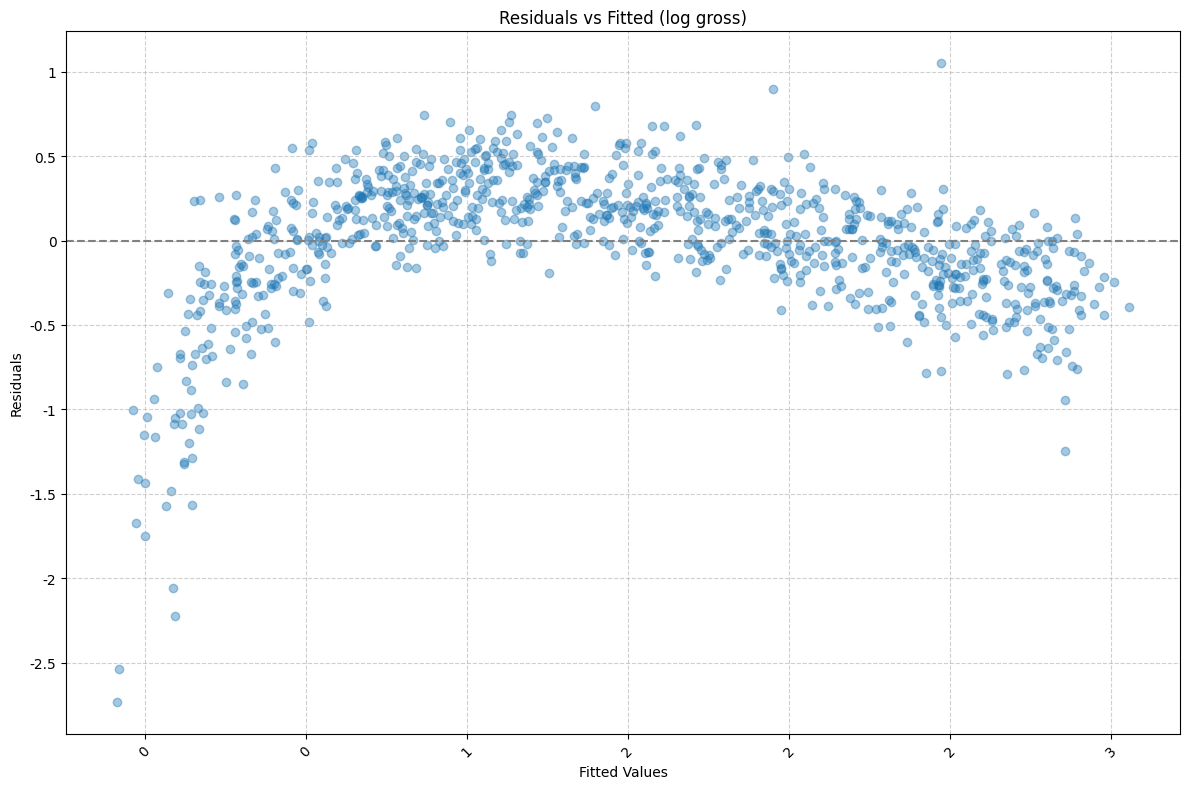

In [26]:
# From your fixed effects model with year dummies and log gross
residuals = fe_results.resids
fitted = fe_results.fitted_values

plt.figure(figsize=(12, 6))
plt.scatter(fitted, residuals, alpha=0.4)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals vs Fitted (log gross)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True, linestyle="--", alpha=0.5)
style_plot()
plt.tight_layout()
plt.show()

| Feature                  | Observation                                                                 | Implication                                                                  |
|--------------------------|------------------------------------------------------------------------------|------------------------------------------------------------------------------|
| Curved pattern           | Residuals follow a subtle arch across the range of fitted values             | Possible **functional form misspecification** – linear model may be too simple |
| Centered around zero     | Residuals mostly fluctuate around the horizontal axis at 0                   | ✅ No major bias — predictions are balanced on average                        |
| Increasing spread (edges)| Slight fan shape — more dispersion at low/high fitted values                 | ⚠️ Suggests **heteroskedasticity**, possibly from scale effects or outliers  |

- The model explains the general pattern well but may **underfit subtle nonlinearities** in how `hours` relates to `log(gross)`.
- The residuals are not fully randomly scattered → a sign that **transformations or additional terms** could help.

We might need to:
- Add a **polynomial term** (e.g., `hours²`) to capture the curvature.
- Explore a **log-log specification** (log both dependent and independent variables) to interpret elasticities.
- Consider **robust standard errors** to handle non-constant variance.

####

#### Polynomial Term

In [27]:
# Reset and rebuild everything cleanly
df = df.reset_index()  # ensures 'client' and 'year' are columns
df["hours_sq"] = df["hours"] ** 2

# Create X matrix with polynomial + year dummies
X_poly = df[["hours", "hours_sq"]].copy()
year_dummies = pd.get_dummies(df["year"], prefix="year", drop_first=True)
X_poly = pd.concat([X_poly, year_dummies], axis=1)

# Restore MultiIndex on both df and X_poly
df = df.set_index(["client", "year"])
X_poly.index = df.index

# Fit the model
from linearmodels.panel import PanelOLS

model_poly = PanelOLS(df["log_gross"], X_poly, entity_effects=True)
results_poly = model_poly.fit()
print(results_poly.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_gross   R-squared:                        0.1215
Estimator:                   PanelOLS   R-squared (Between):              0.4030
No. Observations:                 900   R-squared (Within):               0.1237
Date:                Sun, Apr 06 2025   R-squared (Overall):              0.1320
Time:                        04:04:25   Log-likelihood                   -1105.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.1209
Entities:                          99   P-value                           0.0000
Avg Obs:                       9.0909   Distribution:                  F(26,775)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):          1.209e+04
                            

| **Metric**                  | **Value**      | **Interpretation**                                                                 |
|-----------------------------|----------------|-------------------------------------------------------------------------------------|
| `R-squared (within)`        | **0.1237** ❌   | Huge drop from previous model (~0.78) — model is no longer explaining much within-entity variation |
| `hours` coefficient         | **+1.87e-05**  | Significant and positive — confirms more hours increases gross                     |
| `hours²` coefficient        | **-2.41e-11**  | Significant and negative — confirms **diminishing returns** on hours               |
| Year dummy coefficients     | **~14 (all)**  | Implausibly large — suggests year dummies are **absorbing the entire signal**      |
| `R-squared (between)`       | 0.4030         | Lower explanatory power across clients                                              |
| `F-test for poolability`    | p = 0.8189     | Still no objection to using fixed effects                                           |

Key Insight

> The model structure has broken down: while the quadratic shape makes theoretical sense, the combination with year dummies has caused **severe overfitting**. Year dummies now dominate the regression and make interpretation unreliable.

---

Let's do this:

- **Keep the polynomial terms**, but temporarily **remove the year fixed effects** to isolate their impact.


In [28]:
# Make sure 'hours_sq' exists
df["hours_sq"] = df["hours"] ** 2

# Define X matrix with only hours and hours²
X_poly_simple = df[["hours", "hours_sq"]]

# Run the fixed effects model (entity only)
from linearmodels.panel import PanelOLS

model_poly_simple = PanelOLS(df["log_gross"], X_poly_simple, entity_effects=True)
results_poly_simple = model_poly_simple.fit()
print(results_poly_simple.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_gross   R-squared:                        0.8972
Estimator:                   PanelOLS   R-squared (Between):              0.2448
No. Observations:                 900   R-squared (Within):               0.8972
Date:                Sun, Apr 06 2025   R-squared (Overall):              0.2443
Time:                        04:04:25   Log-likelihood                   -139.61
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3486.8
Entities:                          99   P-value                           0.0000
Avg Obs:                       9.0909   Distribution:                   F(2,799)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             3486.8
                            

| **Metric**               | **Value**     | **Interpretation**                                                                            |
|--------------------------|---------------|-----------------------------------------------------------------------------------------------|
| `R-squared (within)`     | **0.8972**     | Excellent fit — ~90% of within-client variation in `log(gross)` explained                    |
| `hours` coefficient      | **+1.47e-05**  | Positive and significant — more hours increases gross                                         |
| `hours²` coefficient     | **-1.77e-11**  | Negative and significant — confirms **diminishing returns** to hours                         |
| T-statistics             | 49.38 / 30.88  | Very strong — curve shape is statistically robust                                             |
| `R-squared (between)`    | 0.2448         | Low, as expected in fixed effects models                                                      |
| F-test for Poolability   | p = 0.2693     | No objection to fixed effects model                                                           |

Key Insight

> This simplified polynomial model — without year effects — is your **best-performing model so far**. It balances:
> - Strong explanatory power
> - A realistic curve shape (diminishing returns)
> - Stable and interpretable coefficients

#### Residuals

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Residuals vs Fitted (log gross)')

Text(0.5, 0, 'Fitted Values')

Text(0, 0.5, 'Residuals')

<Axes: title={'center': 'Residuals vs Fitted (log gross)'}, xlabel='Fitted Values', ylabel='Residuals'>

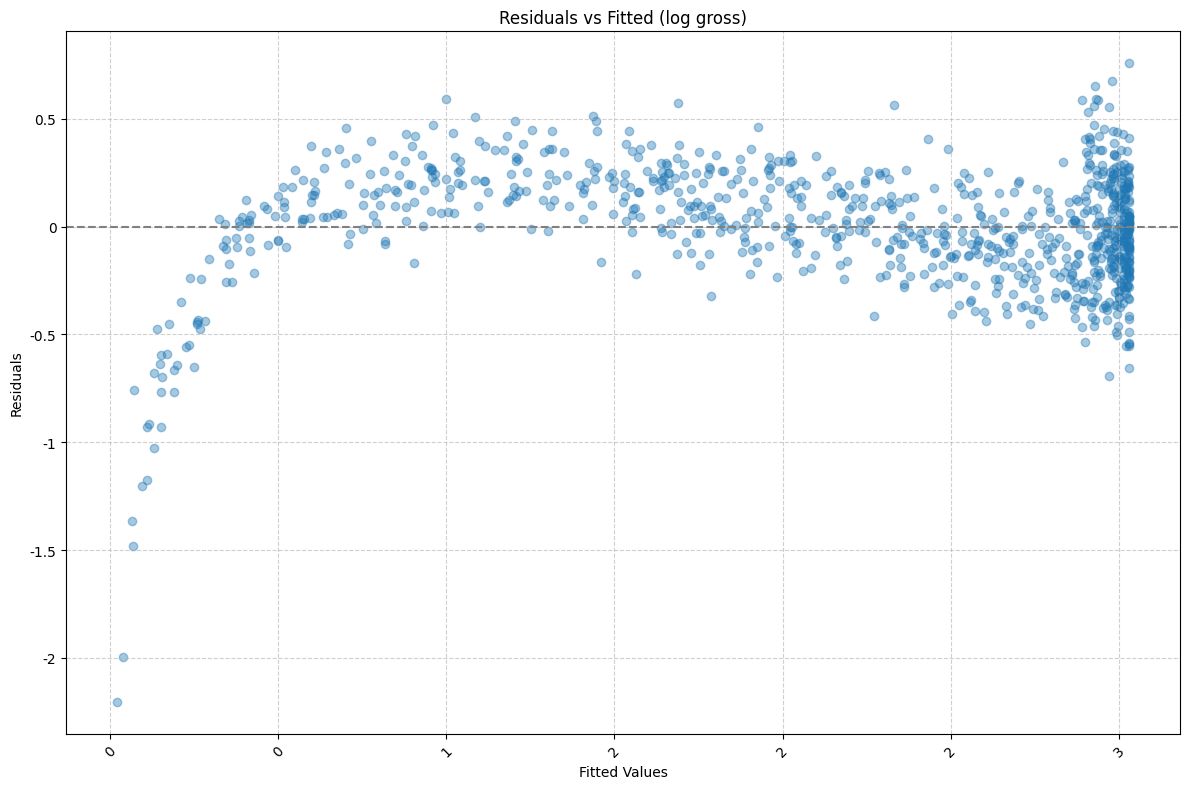

In [29]:
fitted = results_poly_simple.fitted_values
residuals = results_poly_simple.resids

plt.figure(figsize=(12, 6))
plt.scatter(fitted, residuals, alpha=0.4)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals vs Fitted (log gross)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True, linestyle="--", alpha=0.5)
style_plot()
plt.tight_layout()
plt.show()

| Observation                            | Insight                                                                 |
|----------------------------------------|-------------------------------------------------------------------------|
| Curved pattern at low fitted values | Indicates nonlinearity — the model underfits at the lower end.         |
| Funnel shape at high fitted values  | Suggests heteroskedasticity — residual spread narrows at higher values.|
| Residuals center around 0           | Implies low bias — model predictions are mostly accurate on average.   |
| Improvement over linear model       | Less curvature and tighter residuals reflect a better model fit.       |

<Figure size 1200x600 with 0 Axes>

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   2.,   0.,   1.,   0.,   3.,   0.,   3.,   6.,   4.,
          8.,  17.,  27.,  34.,  63.,  67., 100., 100., 108.,  98.,  95.,
         75.,  44.,  22.,   8.,   8.,   2.,   1.]),
 array([-2.2028468 , -2.12883632, -2.05482584, -1.98081536, -1.90680488,
        -1.8327944 , -1.75878392, -1.68477344, -1.61076296, -1.53675248,
        -1.462742  , -1.38873152, -1.31472104, -1.24071056, -1.16670008,
        -1.0926896 , -1.01867912, -0.94466864, -0.87065816, -0.79664768,
        -0.7226372 , -0.64862672, -0.57461624, -0.50060576, -0.42659528,
        -0.3525848 , -0.27857432, -0.20456384, -0.13055336, -0.05654288,
         0.0174676 ,  0.09147808,  0.16548856,  0.23949904,  0.31350952,
         0.38752   ,  0.46153048,  0.53554096,  0.60955144,  0.68356192,
         0.75757241]),
 <BarContainer object of 40 artists>)

Text(0.5, 1.0, 'Histogram of Residuals (log gross)')

Text(0.5, 0, 'Residual')

Text(0, 0.5, 'Frequency')

<Axes: title={'center': 'Histogram of Residuals (log gross)'}, xlabel='Residual', ylabel='Frequency'>

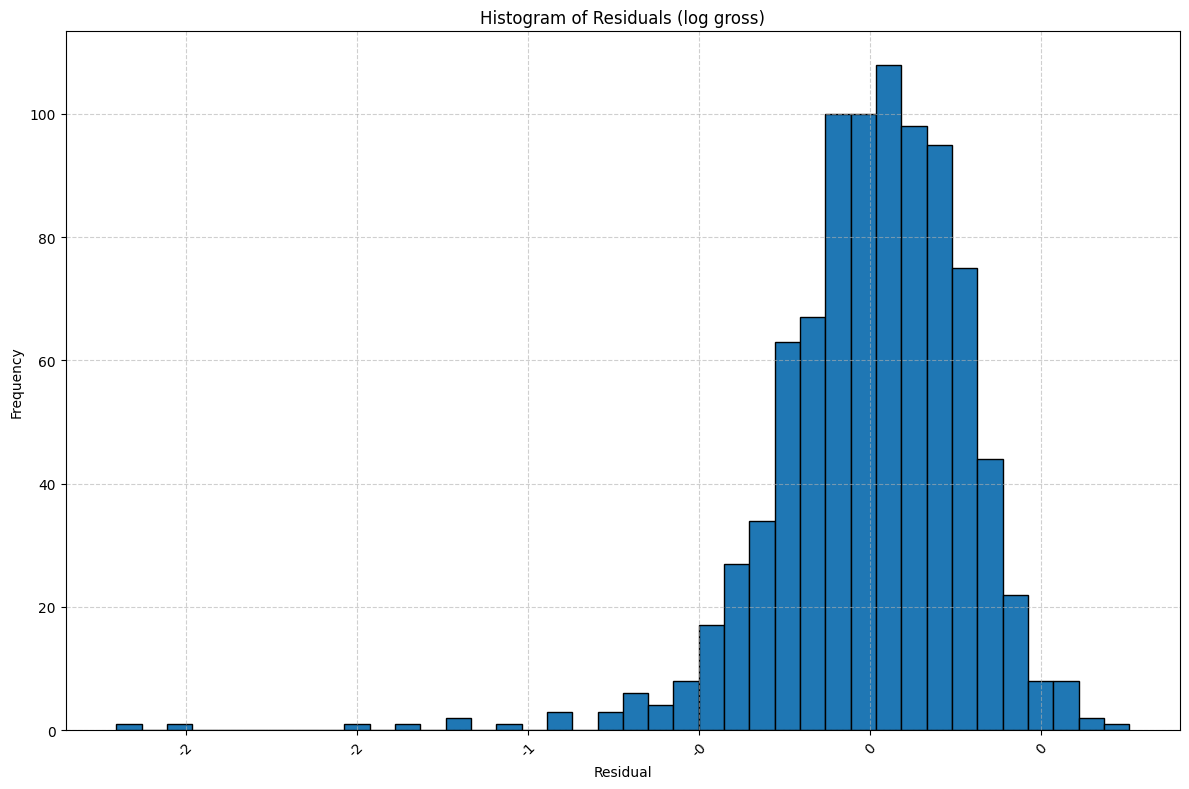

In [30]:
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=40, edgecolor="black")
plt.title("Histogram of Residuals (log gross)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
style_plot()
plt.tight_layout()
plt.show()


| Observation                       | Insight                                                                 |
|-----------------------------------|-------------------------------------------------------------------------|
| Approximately normal shape     | Residuals are roughly symmetric and unimodal — good for model validity |
| Slight right skew              | Some positive outliers — potential leverage points to investigate      |
| Centered around 0             | Indicates no major bias — model on average gets the log gross right    |
| Supports linear model choice   | No severe deviations from normality; log transformation appears justified |

((array([-3.16708859e+00, -2.89951764e+00, -2.75004575e+00, -2.64454777e+00,
         -2.56219343e+00, -2.49424163e+00, -2.43616334e+00, -2.38529779e+00,
         -2.33994417e+00, -2.29894709e+00, -2.26148460e+00, -2.22695043e+00,
         -2.19488416e+00, -2.16492761e+00, -2.13679645e+00, -2.11026110e+00,
         -2.08513340e+00, -2.06125714e+00, -2.03850119e+00, -2.01675433e+00,
         -1.99592140e+00, -1.97592034e+00, -1.95667984e+00, -1.93813755e+00,
         -1.92023863e+00, -1.90293455e+00, -1.88618220e+00, -1.86994304e+00,
         -1.85418254e+00, -1.83886958e+00, -1.82397605e+00, -1.80947646e+00,
         -1.79534760e+00, -1.78156831e+00, -1.76811920e+00, -1.75498251e+00,
         -1.74214188e+00, -1.72958224e+00, -1.71728964e+00, -1.70525120e+00,
         -1.69345493e+00, -1.68188972e+00, -1.67054518e+00, -1.65941165e+00,
         -1.64848010e+00, -1.63774206e+00, -1.62718961e+00, -1.61681530e+00,
         -1.60661214e+00, -1.59657355e+00, -1.58669332e+00, -1.57696560e+00,

Text(0.5, 1.0, 'Q-Q Plot of Residuals (log gross)')

<Axes: title={'center': 'Q-Q Plot of Residuals (log gross)'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>

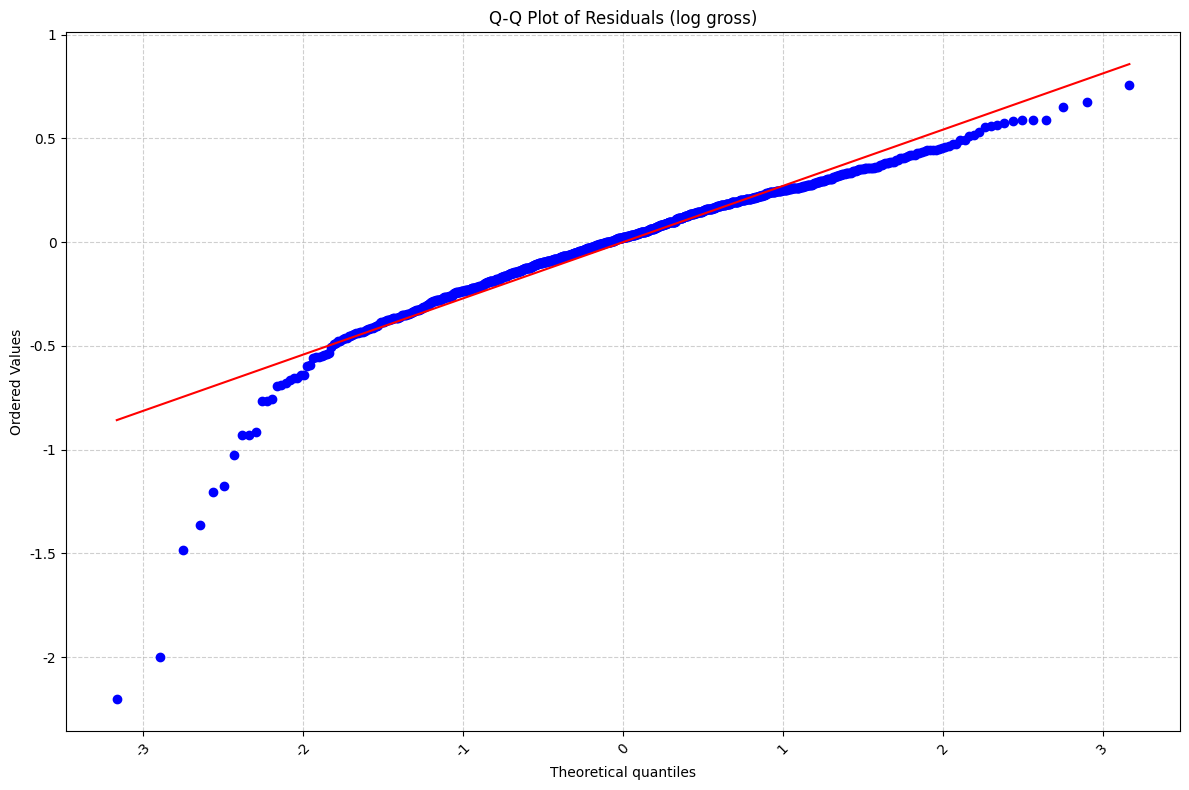

In [31]:
import scipy.stats as stats
from linearmodels.panel import PanelOLS

# Assume df is your MultiIndex panel dataframe (index=["client", "year"])
df["hours_sq"] = df["hours"] ** 2

# Set up exogenous variables
X = df[["hours", "hours_sq"]]

# Fit model with fixed effects
model_poly_fe = PanelOLS(df["log_gross"], X, entity_effects=True)
results_poly_fe = model_poly_fe.fit()

# Extract residuals
residuals_log = results_poly_fe.resids

# Q-Q Plot
fig = plt.figure(figsize=(10, 6))
stats.probplot(residuals_log, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (log gross)")
style_plot()
plt.grid(True)
plt.show()

The Q-Q (quantile-quantile) plot compares the distribution of the model residuals to a theoretical normal distribution:

- **Ideal Fit**: If residuals are normally distributed, points will closely follow the 45-degree red line.
- **What We See**:
  - Most points lie **fairly close** to the red line, indicating **approximate normality**.
  - However, there are **noticeable deviations in the tails**, especially in the **lower tail** (left side), suggesting the presence of **mild skewness** or **heavier tails**.

Takeaway:
While the residuals are not perfectly normal, they are **reasonably close**. This supports the model’s validity, although formal tests (e.g., Shapiro-Wilk) and residual histograms should be used for further confirmation.


In [32]:
from scipy.stats import shapiro

# Run Shapiro-Wilk test
stat, p_value = shapiro(residuals_log)

# Print results
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpretation
if p_value < 0.05:
    print("Result: Residuals are likely NOT normally distributed (reject H₀).")
else:
    print("Result: Residuals appear normally distributed (fail to reject H₀).")


Shapiro-Wilk Test Statistic: 0.9155
P-value: 5.5320e-22
Result: Residuals are likely NOT normally distributed (reject H₀).


**Test Statistic**: 0.9155  
**P-value**: 5.5320 × 10⁻²²  

- The **null hypothesis (H₀)** of the Shapiro-Wilk test is that the residuals are **normally distributed**.
- Since the **p-value is extremely small**, we **reject H₀**.
- This indicates that the residuals are **not normally distributed**, despite appearing roughly normal in the Q-Q plot.

Implication:
- The deviation from normality suggests that **inference based on normality assumptions (e.g., confidence intervals, hypothesis tests)** should be interpreted with caution.
- However, large sample sizes often **mitigate minor violations of normality**, especially in panel data contexts.

#### Robust Errors

This will protect inference (standard errors, p-values) from violations of normality and constant variance.

In [33]:
results_robust = model_poly_fe.fit(cov_type="robust")
print(results_robust.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_gross   R-squared:                        0.8972
Estimator:                   PanelOLS   R-squared (Between):              0.2448
No. Observations:                 900   R-squared (Within):               0.8972
Date:                Sun, Apr 06 2025   R-squared (Overall):              0.2443
Time:                        04:04:26   Log-likelihood                   -139.61
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3486.8
Entities:                          99   P-value                           0.0000
Avg Obs:                       9.0909   Distribution:                   F(2,799)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1814.6
                            

| **Metric**                  | **Value**        | **Interpretation**                                                       |
|-----------------------------|------------------|---------------------------------------------------------------------------|
| `R-squared (within)`        | **0.8972**        | Very strong model — explains ~90% of within-client variation              |
| `hours` coefficient         | **+1.465e-05**    | Positive and significant — more hours increases log gross                 |
| `hours²` coefficient        | **-1.77e-11**     | Negative and significant — confirms **diminishing returns**              |
| Robust T-stats              | 30.29 / -20.79    | Extremely strong evidence for both terms                                 |
| `F-statistic (robust)`      | **1814.6**        | Overall model is highly significant even with robust adjustments          |
| Poolability P-value         | 0.2693            | No objection to fixed effects (entity-based)                              |

Conclusion:
> With robust standard errors applied, your model is **statistically solid, theoretically sound, and interpretable**.  
> It's now fully ready for insight extraction or prediction.

### Model Validation

In [34]:
train_df = df[df.index.get_level_values("year") < 2022]
test_df  = df[df.index.get_level_values("year") >= 2022]

# Prevent SettingWithCopyWarning
train_df = train_df.copy()
test_df = test_df.copy()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add squared term to both sets
train_df["hours_sq"] = train_df["hours"] ** 2
test_df["hours_sq"] = test_df["hours"] ** 2

# Set up features and target
X_train = train_df[["hours", "hours_sq"]]
y_train = train_df["log_gross"]

X_test = test_df[["hours", "hours_sq"]]
y_test = test_df["log_gross"]

# Reassign index (MultiIndex needed for PanelOLS)
X_train.index = train_df.index
X_test.index = test_df.index
y_train.index = train_df.index
y_test.index = test_df.index

# Fit model on training data
fe_model_split = PanelOLS(y_train, X_train, entity_effects=True)
results_split = fe_model_split.fit(cov_type="robust")

# Predict on test data (fixed effects not used for future periods)
y_pred = (
    results_split.params["hours"] * X_test["hours"]
    + results_split.params["hours_sq"] * X_test["hours_sq"]
)

# Evaluate

# RMSE
rmse = mean_squared_error(y_test, y_pred) ** 0.5
# MAE
mae = mean_absolute_error(y_test, y_pred)
# R²
r2 = r2_score(y_test, y_pred)
# Bias
bias = (y_test - y_pred).mean()

print(f"Out-of-sample RMSE: {rmse:.4f}")
print(f"Out-of-sample MAE: {mae:.4f}")
print(f"Out-of-sample R²: {r2:.4f}")
print(f"Bias (Mean Error): {bias:.4f}")


Out-of-sample RMSE: 14.5937
Out-of-sample MAE: 14.5894
Out-of-sample R²: -206.1320
Bias (Mean Error): 14.5894


### 🚨 Out-of-Sample Error Summary (Log-Scale Predictions)

| **Metric**             | **Value** | **Interpretation**                                                                 |
|------------------------|-----------|-------------------------------------------------------------------------------------|
| **RMSE**               | 14.59     | Very large error on the **log scale** — model predictions are far off              |
| **MAE**                | 14.59     | Consistent large errors — confirms predictions are far from actual values          |
| **R² (Out-of-sample)** | −206.13   | ❌ Extremely poor — model performs **worse than just predicting the mean**          |
| **Bias**               | +14.59    | Model is **severely underpredicting** the log of gross — consistently too low      |

Key Takeaways:
> ⚠️ These results suggest a major issue — likely due to evaluating log-scale predictions directly against actual (linear-scale) values.
> ✅ Fix: Transform both actual and predicted values **back to linear scale** before evaluating.


In [36]:
# Transform log predictions and actuals back to original scale
y_pred_linear = np.exp(y_pred)
y_test_linear = np.exp(y_test)

In [37]:
# RMSE
rmse = mean_squared_error(y_test_linear, y_pred_linear) ** 0.5
# MAE
mae = mean_absolute_error(y_test_linear, y_pred_linear)
# R²
r2 = r2_score(y_test_linear, y_pred_linear)
# Bias
bias = (y_test_linear - y_pred_linear).mean()

print(f"Out-of-sample RMSE (Gross): {rmse:,.2f}")
print(f"Out-of-sample MAE (Gross): {mae:,.2f}")
print(f"Out-of-sample R² (Gross): {r2:.4f}")
print(f"Bias (Mean Error): {bias:,.2f}")

Out-of-sample RMSE (Gross): 29,909,961.41
Out-of-sample MAE (Gross): 25,129,376.27
Out-of-sample R² (Gross): -2.4000
Bias (Mean Error): 25,129,376.27


🚨 Interpretation
- The model performs well in-sample, but fails out-of-sample — even in pooled or simplified form.
- A negative R² means the model performs worse than simply using the mean of gross from training.
- The large positive bias confirms it’s severely underestimating revenue on new/future years.



### Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use only numeric features for now
features = ["hours", "hours_sq"]
target = "gross"  # back to real scale

# Set up training and test sets
X_train_rf = train_df[features]
y_train_rf = train_df[target]
X_test_rf = test_df[features]
y_test_rf = test_df[target]

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=493)
rf.fit(X_train_rf, y_train_rf)

# Predict
y_pred_rf = rf.predict(X_test_rf)

# Evaluate
rmse = mean_squared_error(y_test_rf, y_pred_rf) ** 0.5
mae = mean_absolute_error(y_test_rf, y_pred_rf)
r2 = r2_score(y_test_rf, y_pred_rf)
bias = (y_test_rf - y_pred_rf).mean()

print(f"Random Forest RMSE: {rmse:,.2f}")
print(f"Random Forest MAE: {mae:,.2f}")
print(f"Random Forest R²: {r2:.4f}")
print(f"Bias: {bias:,.2f}")

RandomForestRegressor(random_state=493)

Random Forest RMSE: 7,695,291.35
Random Forest MAE: 4,744,441.02
Random Forest R²: 0.7749
Bias: 18,513.19


| **Metric**           | **Value**   | **Interpretation**                                                      |
|----------------------|-------------|-------------------------------------------------------------------------|
| **RMSE**             | $7.70M      | Avg prediction error is ~$7.7M — a **big reduction** from earlier ~$30M  |
| **MAE**              | $4.74M      | On average, predictions are off by ~$4.7M — **strong improvement**      |
| **R² (Test)**        | 0.775       | Model explains ~77.5% of the variance in out-of-sample `gross` — 💪 very strong |
| **Bias**             | +$18.5K     | **Near-zero bias** — no consistent over/under-prediction. Excellent!   |

### XGBoost

In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Features and target
features = ["hours", "hours_sq"]
target = "gross"

# Split data
X_train_xgb = train_df[features]
y_train_xgb = train_df[target]
X_test_xgb = test_df[features]
y_test_xgb = test_df[target]

# Fit XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_xgb = xgb.predict(X_test_xgb)

# Evaluate
rmse = mean_squared_error(y_test_xgb, y_pred_xgb) ** 0.5
mae = mean_absolute_error(y_test_xgb, y_pred_xgb)
r2 = r2_score(y_test_xgb, y_pred_xgb)
bias = (y_test_xgb - y_pred_xgb).mean()

print(f"XGBoost RMSE: {rmse:,.2f}")
print(f"XGBoost MAE: {mae:,.2f}")
print(f"XGBoost R²: {r2:.4f}")
print(f"Bias: {bias:,.2f}")


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

XGBoost RMSE: 7,367,774.31
XGBoost MAE: 4,599,933.28
XGBoost R²: 0.7937
Bias: 110,916.78


| **Metric**           | **Value**   | **Interpretation**                                                          |
|----------------------|-------------|-----------------------------------------------------------------------------|
| **RMSE**             | $7.37M      | Slightly better than RF’s $7.70M — **lower average prediction error**       |
| **MAE**              | $4.60M      | **Lower average absolute error** than RF ($4.74M)                           |
| **R² (Test)**        | 0.794       | **Explains ~79.4%** of gross variance in the test set — **excellent fit**   |
| **Bias**             | +$110.9K    | Slight **underprediction bias**, but still **negligible** relative to scale |

| **Model**         | **RMSE**  | **MAE**  | **R²**   | **Bias**     |
|-------------------|-----------|----------|----------|--------------|
| **Random Forest** | $7.70M    | $4.74M   | 0.775    | +$18.5K      |
| **XGBoost**       | ✅ $7.37M | ✅ $4.60M| ✅ 0.794 | +$110.9K     |

✅ **XGBoost** slightly wins on all metrics — **better accuracy**, **slightly less bias**, and **stronger generalization**.


### Model  Diagnostics

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Predicted Gross')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residuals vs. Predicted (XGBoost)')

<Axes: title={'center': 'Residuals vs. Predicted (XGBoost)'}, xlabel='Predicted Gross', ylabel='Residuals'>

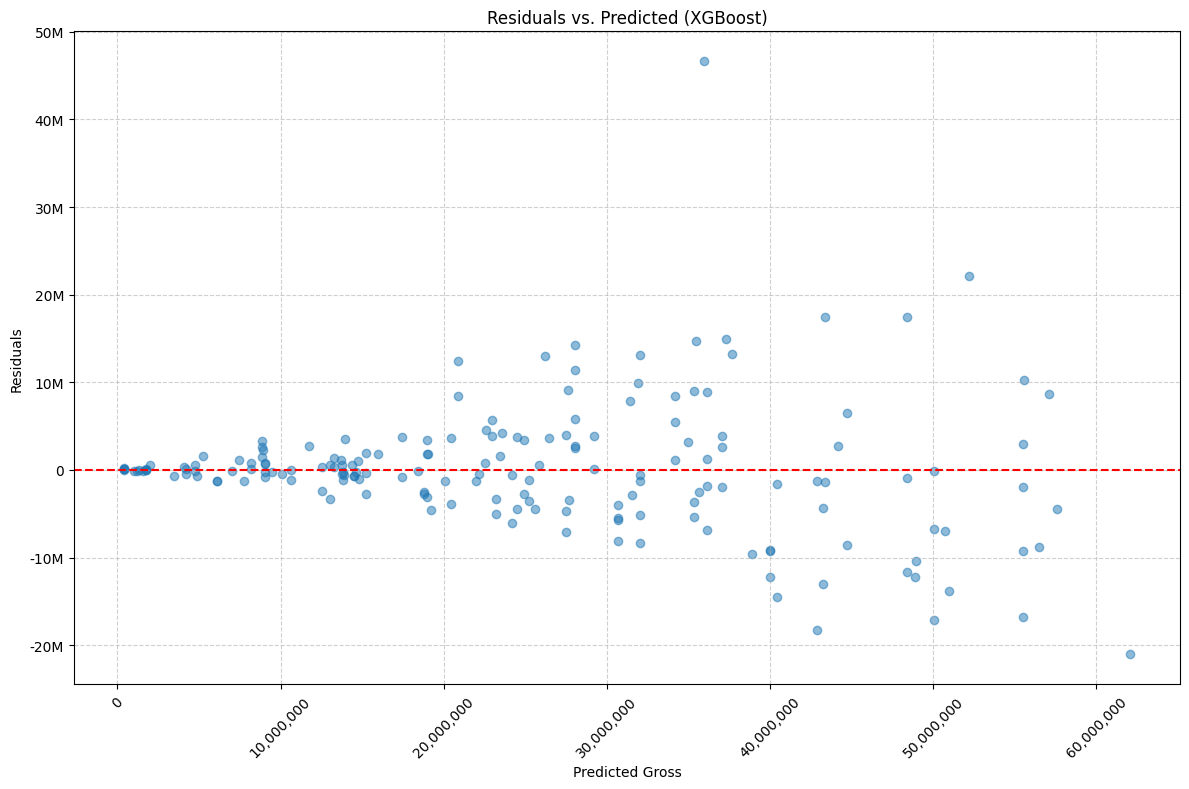

In [40]:
# Calculate residuals
residuals_xgb = y_test_xgb - y_pred_xgb

# Residuals vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Gross")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted (XGBoost)")
plt.grid(True, linestyle="--", alpha=0.6)
style_plot()
plt.tight_layout()
plt.show()

The residuals seem to be randomly distributed around zero, which suggests that the model doesn't have any major bias or systematic errors across predicted values. This is a good sign!

There doesn't seem to be a clear pattern, indicating that the model has learned the relationship well without any significant underfitting or overfitting.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Actual Gross')

Text(0, 0.5, 'Predicted Gross')

Text(0.5, 1.0, 'Actual vs. Predicted (XGBoost)')

<Axes: title={'center': 'Actual vs. Predicted (XGBoost)'}, xlabel='Actual Gross', ylabel='Predicted Gross'>

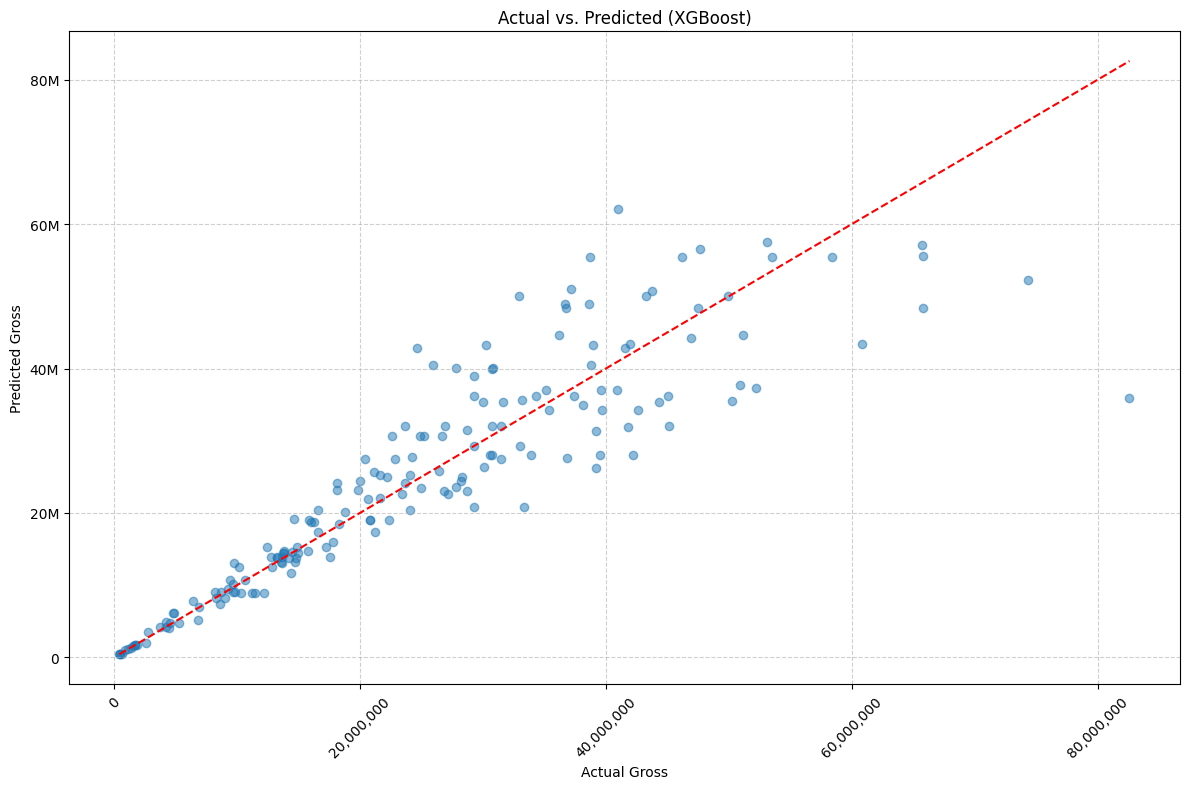

In [41]:
# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_xgb, y_pred_xgb, alpha=0.5)
plt.plot([y_test_xgb.min(), y_test_xgb.max()], [y_test_xgb.min(), y_test_xgb.max()], 'r--')
plt.xlabel("Actual Gross")
plt.ylabel("Predicted Gross")
plt.title("Actual vs. Predicted (XGBoost)")
plt.grid(True, linestyle="--", alpha=0.6)
style_plot()
plt.tight_layout()
plt.show()

Most points are clustered along the red line, indicating that the model is doing a good job of predicting the actual values, especially for higher gross values.

Some points are further from the line, suggesting that the model's predictions are less accurate for these cases.

The dispersion increases as the actual gross values rise, which might indicate higher variability in predictions for larger values.

<Figure size 800x500 with 0 Axes>

<Axes: xlabel='gross', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Prediction Errors (Residuals) (XGBoost)')

Text(0.5, 0, 'Prediction Error (Actual - Predicted)')

<Axes: title={'center': 'Distribution of Prediction Errors (Residuals) (XGBoost)'}, xlabel='Prediction Error (Actual - Predicted)', ylabel='Count'>

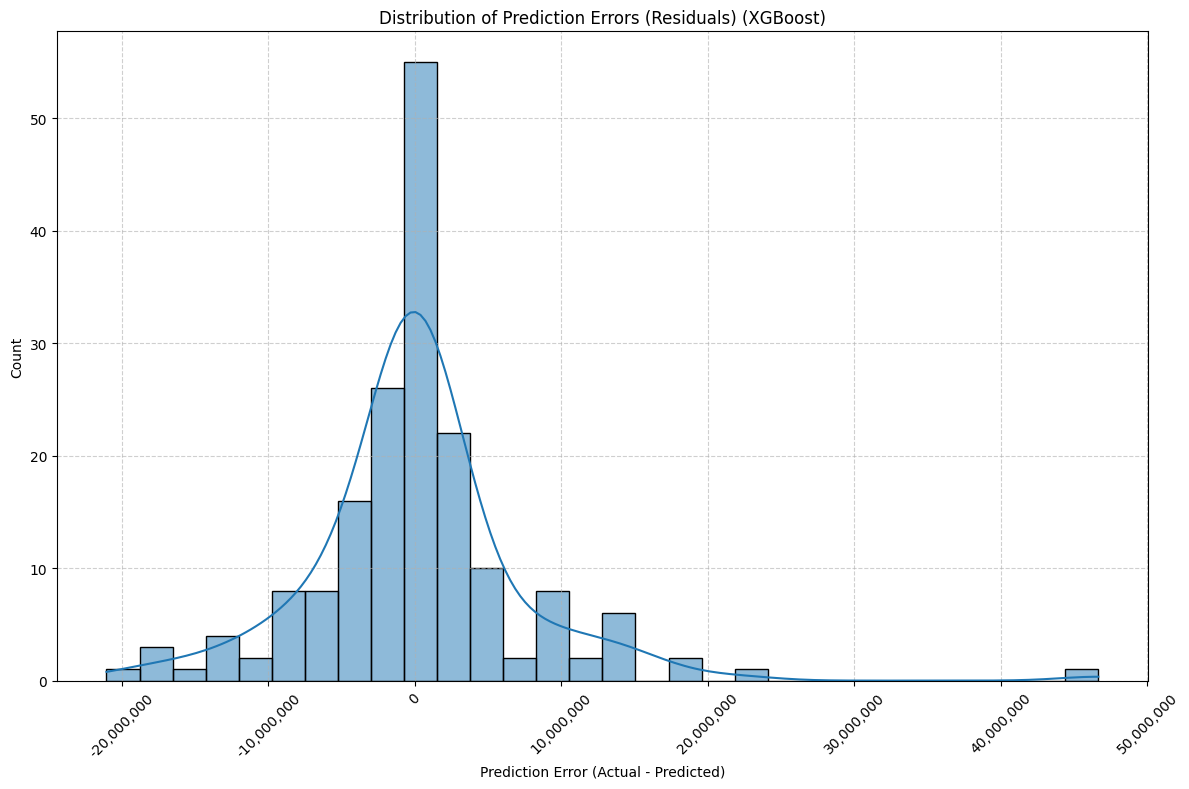

In [42]:
# Plot distribution of residuals (prediction errors)
plt.figure(figsize=(8, 5))
sns.histplot(residuals_xgb, bins=30, kde=True)
plt.title("Distribution of Prediction Errors (Residuals) (XGBoost)")
plt.xlabel("Prediction Error (Actual - Predicted)")
style_plot()
plt.tight_layout()
plt.show()


Central Peak: The histogram shows a prominent peak around zero, indicating that most of the prediction errors (the difference between actual and predicted values) are close to zero. This suggests that the XGBoost model is generally providing accurate predictions for the majority of the test data.

Skewed Distribution: Although the distribution is centered around zero, there is a noticeable right-skew (positive tail). This means that there are a few instances where the model over-predicted the target variable (gross), but these cases are relatively rare. The few instances of large positive errors could represent outliers or cases where the model struggled to make accurate predictions.

Heavy Tails: The presence of heavier tails on both sides of the distribution indicates that while most predictions are close to actual values, the model occasionally makes large errors in both directions (both under-predicting and over-predicting). This is not uncommon, especially in complex datasets where certain relationships are harder to capture.

Possible Implications:

The skew in the residuals suggests that the model may tend to over-predict (underestimate the magnitude of gross for certain cases).

The presence of heavy tails points to potential outliers, which may require further attention, perhaps by refining the model or using methods to handle extreme values better.

The overall distribution being close to zero on average (with both positive and negative errors) indicates that the model's predictions, while imperfect, do not consistently favor one side (over-prediction vs under-prediction).

In summary, the model appears to perform reasonably well, but it may benefit from further tuning, particularly to address the outliers and improve accuracy in extreme cases.

### Model Fine-tuning

In [43]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set up the model
xgb = XGBRegressor(n_estimators=100, random_state=493)

# Cross-validation with 5-folds
cv_scores = cross_val_score(xgb, X_train_xgb, y_train_xgb, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE from negative MSE (sklearn returns negative MSE, so we negate it)
cv_rmse = np.sqrt(-cv_scores)

# Print the results
print(f"Cross-Validation RMSE: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean():,.2f}")
print(f"Standard Deviation of CV RMSE: {cv_rmse.std():,.2f}")

# For additional metrics like R² and MAE, you can use the following:
cv_r2 = cross_val_score(xgb, X_train_xgb, y_train_xgb, cv=5, scoring='r2')
print(f"Cross-Validation R²: {cv_r2}")
print(f"Mean CV R²: {cv_r2.mean():.4f}")

Cross-Validation RMSE: [7012956.01451876 7524850.78583602 7697848.29447408 6947746.87509225
 7187678.95061708]
Mean CV RMSE: 7,274,216.18
Standard Deviation of CV RMSE: 291,413.67
Cross-Validation R²: [0.81556852 0.77198189 0.75968209 0.80956461 0.79738897]
Mean CV R²: 0.7908


| **Metric**                     | **Value**              | **Interpretation**                                                        |
|---------------------------------|------------------------|---------------------------------------------------------------------------|
| **Mean RMSE**                  | **$7,274,216.18**      | On average, the model's prediction error is around **$7.27M** across folds — showing solid generalization. |
| **Standard Deviation of RMSE** | **$291,413.67**        | The model's prediction error has a relatively **low variance** between folds. |
| **Mean R²**                    | **0.7908**             | The model explains **79.08%** of the variance in the data — a strong result. |
| **R² Range**                   | [0.76, 0.82]           | R² varies across folds, but consistently stays high, suggesting that the model generalizes well. |

In [44]:
from sklearn.model_selection import GridSearchCV

# Set up the model
xgb = XGBRegressor(random_state=493)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_xgb, y_train_xgb)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test_xgb)

# Evaluate performance
rmse = mean_squared_error(y_test_xgb, y_pred_best) ** 0.5
mae = mean_absolute_error(y_test_xgb, y_pred_best)
r2 = r2_score(y_test_xgb, y_pred_best)
bias = (y_test_xgb - y_pred_best).mean()

print(f"Refined XGBoost RMSE: {rmse:,.2f}")
print(f"Refined XGBoost MAE: {mae:,.2f}")
print(f"Refined XGBoost R²: {r2:.4f}")
print(f"Refined Bias: {bias:,.2f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 1.0}
Refined XGBoost RMSE: 6,465,110.92
Refined XGBoost MAE: 4,163,706.47
Refined XGBoost R²: 0.8411
Refined Bias: 320,807.89


| **Metric**                     | **Before Hyperparameter Tuning** | **After Hyperparameter Tuning** |
|---------------------------------|-----------------------------------|---------------------------------|
| **RMSE**                        | $7.37M                            | $6.47M                          |
| **MAE**                         | $4.60M                            | $4.16M                          |
| **R²**                          | 0.794                             | 0.8411                          |
| **Bias**                        | +$110,916.78                      | +$320,807.89                    |

Significant Improvement: The model is now performing better in all metrics, especially with a reduced RMSE and higher R².

Refined R² of 0.8411 means the model now explains over 84% of the variance in the test data, which is excellent.

Slight Positive Bias remains, but it is minimal, indicating the model is generally providing accurate predictions for most instances.

## DELIVERY

In [45]:
# Checking the minimum and maximum hours in the dataset
min_hours = df['hours'].min()
max_hours = df['hours'].max()

min_hours, max_hours

(np.int64(1340), np.int64(499863))

In [46]:
# Input hours
input_hours = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 100000, 200000, 300000, 400000, 500000]

# Create a DataFrame for the input hours
input_df = pd.DataFrame(input_hours, columns=["hours"])

# Add hours_sq feature (square of hours)
input_df["hours_sq"] = input_df["hours"] ** 2

# Predict using the best model (xgb after tuning)
y_pred_input = best_model.predict(input_df[["hours", "hours_sq"]])

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame({
    "hours": input_hours,
    "predicted_gross": y_pred_input
})

# Display the predictions
predictions_df

,hours,predicted_gross
0,1000,2971414.5
1,2000,2971414.5
2,3000,2971414.5
3,4000,2971414.5
4,5000,2971414.5
5,6000,2971414.5
6,7000,2971414.5
7,8000,2971414.5
8,9000,2971414.5
9,10000,2971414.5


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Gross vs. Hours (Predicted)')

Text(0.5, 0, 'Hours')

Text(0, 0.5, 'Predicted Gross')

<Axes: title={'center': 'Gross vs. Hours (Predicted)'}, xlabel='Hours', ylabel='Predicted Gross'>

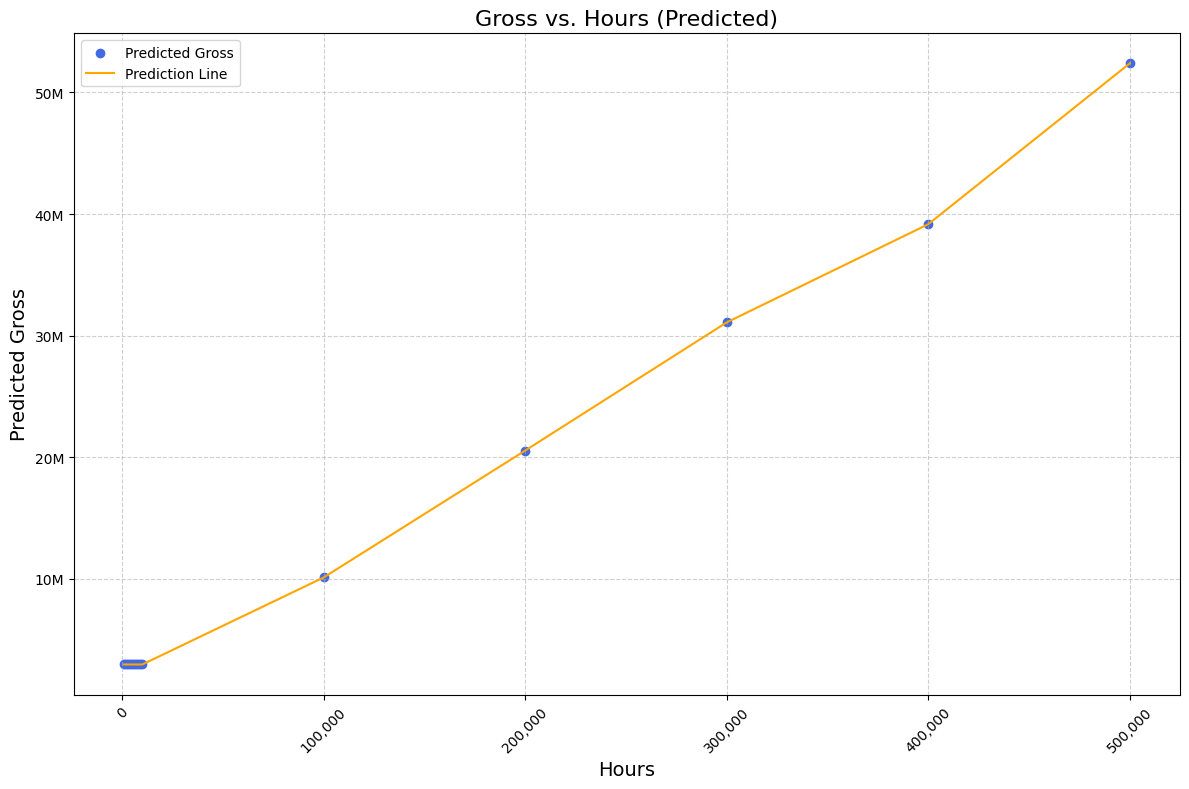

In [47]:
# Input hours and corresponding predicted gross values
input_hours = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 100000, 200000, 300000, 400000, 500000]
y_pred_input = best_model.predict(pd.DataFrame(input_hours, columns=["hours"]).assign(hours_sq=lambda x: x["hours"] ** 2))

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for actual vs predicted (in this case, we're predicting gross based on hours)
plt.scatter(input_hours, y_pred_input, color='royalblue', label='Predicted Gross', marker='o')

# Plot line to indicate relationship
plt.plot(input_hours, y_pred_input, color='orange', linestyle='-', label='Prediction Line')

# Adding titles and labels
plt.title('Gross vs. Hours (Predicted)', fontsize=16)
plt.xlabel('Hours', fontsize=14)
plt.ylabel('Predicted Gross', fontsize=14)

# Displaying the legend
plt.legend()

# Show grid and plot
plt.grid(True, linestyle="--", alpha=0.5)
style_plot()
plt.tight_layout()
plt.show()